# Espectrograma

In [ ]:
%reset -f
import numpy as np
from scipy.io import wavfile
import IPython.display as ipd
from scipy import signal as sig
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

In [ ]:
# Parámetros para hacer el recorte temporal de la señal
fs_r = 8000

to = 22/1000
tf = 82/1000

no = int(np.round(to * fs_r)) 
nf = int(np.round(tf * fs_r)) 

tiempos       = (1000/fs_r)*np.arange(0,nf-no)


#==========================================================================================================================================================================#
archivo = "M01_normal_low"

archivo_mic         = 'Repositorio IV/'+archivo+'_mic.wav'
fs_mic,señal_mic = wavfile.read(archivo_mic)

señal_mic   = sig.resample(señal_mic, len(señal_mic)*fs_r//fs_mic)

señal_mic = señal_mic[no:nf]
señal_mic_plot = señal_mic

#==========================================================================================================================================================================#
archivo_EGG      = 'Repositorio IV/'+archivo+'_EGG.wav'
fs_EGG,señal_EGG = wavfile.read(archivo_EGG)


señal_EGG   = sig.resample(señal_EGG, len(señal_EGG)*fs_r//fs_EGG)
señal_EGG   = señal_EGG[no:nf]

señal_dEGG  = np.gradient(señal_EGG,tiempos)

#==========================================================================================================================================================================#


fig,ax = plt.subplots(figsize=(15,4))

ax.plot(tiempos,señal_EGG,color='b');
ax.set_xlabel('tiempo [ms]');
#ax.grid(True,linestyle='dashed',color='gray',alpha=0.5)

ax1_ = ax.twinx()
ax1_.plot(tiempos,señal_dEGG,color='r',label='dEGG');
ax1_.plot(tiempos[3],señal_EGG[3],color='b',label="EGG")
ax1_.legend();
titulo  = archivo_EGG
ax.set_title(titulo);

In [ ]:
# Filtro de pre-énfasis H(z) = 1 - z^-1
b = [1, -1]
a = [1]

#señal_mic = sig.filtfilt(b,a,señal_mic)
señal_mic = sig.lfilter(b,a,señal_mic)


In [ ]:
duracion_ventana = 5.5 # En ms
longitud_ventana = int(np.round(fs_r*duracion_ventana/1000))
desplazamiento   = 1    
ventana          = sig.windows.boxcar(longitud_ventana)


'''
Si 
    Ns = cantidad de elementos de la señal.
    Nv = cantidad de elementos de la ventana.
    d  = cantidad de elementos que se desplaza la ventana.

La cantidad de ventanas que voy a tener va a ser igual a 
    Cv = 1 + (NS-Nv)/d

'''
cantidad_ventanas = int( 1 + np.floor(( len(señal_mic) - longitud_ventana) / desplazamiento))

matriz_STFT     = np.zeros([longitud_ventana,cantidad_ventanas],dtype=complex)

for i in range(cantidad_ventanas):
    # Esto me da la posición inicial en la señal a partir de la cual voy a hacer el ventaneo
    inicio   = i*desplazamiento

    # Esto me da una lista de la forma [0, 1, 2, ...,longitud_ventana - 1 ]
    desp_rel = np.arange(longitud_ventana)
    '''
    La suma me da un resultado de la forma 

       [inicio + 0,inicio + 1,inicio + 2, ..., inicio + longitud_ventana - 1]

    '''
    posicion_ventana   = inicio + desp_rel 

    señal_ventaneada   = np.multiply( ventana, señal_mic[posicion_ventana])
    matriz_STFT[:,i] = np.fft.fft(señal_ventaneada)
        

# Me quedo con la mitad de los elementos
cantidad_frec_unicas =  int((longitud_ventana + 1)/2)
matriz_STFT          = matriz_STFT[range(cantidad_frec_unicas), :]

# Creo el espectrograma teniendo en cuenta la compresión del paper
p = 0.55
espectrograma =np.abs(matriz_STFT)**p 


In [ ]:
fig,ax = plt.subplots(3,1,figsize=(14,7),gridspec_kw={'height_ratios': [1,3, 1]})
plt.subplots_adjust(left=None, bottom=0.5, right=None, top=1.7, wspace=None, hspace=None)

to_espec = duracion_ventana
tf_espec = (tf-to)*1000
fo = 0
ff = fs_r/2000

ax[0].plot(tiempos,señal_EGG,color='b');
ax[0].set_xlabel('tiempo [ms]');

ax[0].set_xticks(np.arange(0,tf_espec,duracion_ventana))
ax[0].set_xlim([0,60]);
ax0_ = ax[0].twinx()
ax0_.plot(tiempos,señal_dEGG,color='r',label='dEGG');
ax0_.plot(tiempos[3],señal_EGG[3],color='b',label="EGG")
ax0_.legend(loc='upper right');
ax0_.set_title(titulo,pad=20);



ax[1].imshow(espectrograma,cmap = 'viridis',origin='lower',aspect='auto',extent=[to_espec,tf_espec,fo,ff]);
ax[1].set_xlabel("t [ms]");
ax[1].set_ylabel(r"$f$ [kHz]");
ax1_ = ax[1].twinx()
ax1_.plot(tiempos[longitud_ventana-1:],señal_dEGG[longitud_ventana-1:],color='white',label="dEGG",linewidth=2);
ax1_.legend(loc='upper right');
ax1_.set_xticks(np.arange(duracion_ventana,tf_espec,duracion_ventana))
ax1_.set_xlim(to_espec,tf_espec)
ax1_.set_ylim([min(señal_dEGG)-max(señal_dEGG),max(señal_dEGG)+max(señal_dEGG)]);
ax1_.set_yticks([]);


energia = []
for i in range(0,matriz_STFT.shape[1]):
    energia.append(np.sum(np.abs(matriz_STFT[:,i])**2))

maximo = max(energia)
energia = [valor/maximo for valor in energia]
ax[2].plot(np.linspace(5.5,60,len(energia)),energia,color='orange',label=r"$|FFT|^2$");
ax[2].set_xlabel('tiempo [ms]');
ax[2].set_xlim(to_espec,tf_espec)
ax[2].set_xticks(np.arange(5.5,tf_espec,duracion_ventana))
ax[2].set_xlim([5.5,60]);
ax[2].legend(loc='upper right');

#fig.savefig('M01_normal_medium_EGG.pdf',bbox_inches = 'tight')


# Prueba de filtros

In [ ]:
%reset -f
import numpy as np
from scipy.io import wavfile
import IPython.display as ipd
from scipy import signal as sig
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

In [ ]:
def FFT(señal, fs):
    N   = len(señal)
    fft = np.fft.fft(señal,norm='forward')
    
    magnitud = np.abs(fft)
    freqs = np.fft.fftfreq(N, 1/fs)

    return magnitud[:N // 2],freqs[:N // 2] 

In [ ]:
# Parámetros para hacer el recorte temporal de la señal
fs_r = 8000

to = 25/1000
tf = 55/1000

no = int(np.round(to * fs_r)) 
nf = int(np.round(tf * fs_r)) 

tiempos = (1000/fs_r)*np.arange(0,nf-no)

caso = "M05_normal"
archivo_low = caso + "_low"
archivo_medium = caso + "_medium"
archivo_high = caso + "_high"

archivo_EGG_low     = 'Repositorio IV/'+archivo_low+'_EGG.wav'
archivo_EGG_medium  = 'Repositorio IV/'+archivo_medium+'_EGG.wav'
archivo_EGG_high    = 'Repositorio IV/'+archivo_high+'_EGG.wav'

fs_EGG,señal_EGG_low    = wavfile.read(archivo_EGG_low)
fs_EGG,señal_EGG_medium = wavfile.read(archivo_EGG_medium)
fs_EGG,señal_EGG_high   = wavfile.read(archivo_EGG_high)


señal_EGG_low   = sig.resample(señal_EGG_low, len(señal_EGG_low)*fs_r//fs_EGG)
señal_EGG_low   = señal_EGG_low[no:nf]
maximo          = max(señal_EGG_low)
señal_EGG_low   = [valor/maximo for valor in señal_EGG_low]

señal_EGG_medium   = sig.resample(señal_EGG_medium, len(señal_EGG_medium)*fs_r//fs_EGG)
señal_EGG_medium   = señal_EGG_medium[no:nf]
maximo             = max(señal_EGG_medium)
señal_EGG_medium   = [valor/maximo for valor in señal_EGG_medium]

señal_EGG_high   = sig.resample(señal_EGG_high, len(señal_EGG_high)*fs_r//fs_EGG)
señal_EGG_high   = señal_EGG_high[no:nf]
maximo           = max(señal_EGG_high)
señal_EGG_high   = [valor/maximo for valor in señal_EGG_high]
#==========================================================================================================================================================================#


fig,ax = plt.subplots(11,3,figsize=(30,30))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.35, hspace=0.65)
fig.suptitle("Caso: "+ str(caso), fontsize=32,y=0.91);

fci = 80
fcs = np.arange(1000,2100,100)
N  = 2

ax[0][0].plot(tiempos,señal_EGG_low,color="blue")
ax[0][0].set_title("Low - Sin filtrar")
ax[0][0].set_xlabel("t [ms]")
ax_00 = ax[0][0].twinx()
dEGG_low = np.gradient(señal_EGG_low)
maximo = max(dEGG_low)
dEGG_low = [valor/maximo for valor in dEGG_low]

ax_00.plot(tiempos,dEGG_low,label="dEGG",color="red")
ax_00.plot(tiempos[0],señal_EGG_low[0],color='b',label="EGG")
#ax_00.set_ylim([min(np.gradient(señal_EGG_low)),max(np.gradient(señal_EGG_low))])
ax_00.legend(loc='upper left')


ax[0][1].plot(tiempos,señal_EGG_medium,color="blue")
ax[0][1].set_title("Medium - Sin filtrar")
ax[0][1].set_xlabel("t [ms]")

ax_01 = ax[0][1].twinx()
dEGG_medium = np.gradient(señal_EGG_medium)
maximo = max(dEGG_medium)
dEGG_medium = [valor/maximo for valor in dEGG_medium]

ax_01.plot(tiempos,dEGG_medium,label="dEGG",color="red")
ax_01.plot(tiempos[0],señal_EGG_medium[0],color='b',label="EGG")
ax_01.legend(loc='upper left')

ax[0][2].plot(tiempos,señal_EGG_high,color="blue")
ax[0][2].set_title("High - Sin filtrar")
ax[0][2].set_xlabel("t [ms]")

ax_02 = ax[0][2].twinx()
dEGG_high = np.gradient(señal_EGG_high)
maximo = max(dEGG_high)
dEGG_high = [valor/maximo for valor in dEGG_high]
ax_02.plot(tiempos,dEGG_high,label="dEGG",color="red")
ax_02.plot(tiempos[0],señal_EGG_high[0],color='b',label="EGG")
ax_02.legend(loc='upper left')

señales = [señal_EGG_low,señal_EGG_medium,señal_EGG_high]
etiquetas = ['Low','Medium','High']

for i in range(1,11,1):
    for j in range(0,3,1):
      b, a = sig.butter(N, [fci,fcs[i-1]],'bandpass',fs=fs_r)
      w, h = sig.freqz(b,a,fs=fs_r)
      EGG  = sig.filtfilt(b,a,señales[j])
      dEGG = np.gradient(EGG)
      
      maximo = max(dEGG)
      dEGG   = [valor/maximo for valor in dEGG]
      ax[i][j].plot(tiempos,EGG,color="blue")
      ax_ = ax[i][j].twinx()
      ax_.plot(tiempos,dEGG,color="red")
      ax[i][j].set_xlabel("t [ms]")
      ax[i][j].set_title(str(etiquetas[j])+" - Butterworth orden "+str(N)+" -  80 ~"+str(str(fcs[i-1]))+" [Hz]")
    #ax[i][j].annotate(+r" [Hz]", rotation=90, xy=(-12,min(EGG)), xycoords='data',fontsize=12 ,annotation_clip=False);

fig.savefig("Prueba de filtros/"+caso+"_filtrada.pdf",bbox_inches = 'tight')


# Espectro individual

In [ ]:
%reset -f
import numpy as np
from scipy.io import wavfile
import IPython.display as ipd
from scipy import signal as sig
from scipy.linalg import solve_toeplitz
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

parula_data = [
    [0.2081, 0.1663, 0.5292],
    [0.2116, 0.1898, 0.5777],
    [0.2123, 0.2138, 0.6270],
    [0.2081, 0.2386, 0.6771],
    [0.1959, 0.2645, 0.7279],
    [0.1707, 0.2919, 0.7792],
    [0.1253, 0.3242, 0.8303],
    [0.0591, 0.3598, 0.8683],
    [0.0117, 0.3875, 0.8820],
    [0.0050, 0.4086, 0.8828],
    [0.0165, 0.4266, 0.8786],
    [0.0329, 0.4430, 0.8720],
    [0.0498, 0.4586, 0.8641],
    [0.0629, 0.4737, 0.8554],
    [0.0723, 0.4887, 0.8467],
    [0.0779, 0.5040, 0.8384],
    [0.0793, 0.5200, 0.8312],
    [0.0749, 0.5375, 0.8263],
    [0.0641, 0.5570, 0.8240],
    [0.0488, 0.5772, 0.8228],
    [0.0343, 0.5966, 0.8199],
    [0.0265, 0.6137, 0.8135],
    [0.0239, 0.6287, 0.8038],
    [0.0231, 0.6418, 0.7913],
    [0.0228, 0.6535, 0.7768],
    [0.0267, 0.6642, 0.7607],
    [0.0384, 0.6743, 0.7436],
    [0.0590, 0.6838, 0.7254],
    [0.0843, 0.6928, 0.7062],
    [0.1133, 0.7015, 0.6859],
    [0.1453, 0.7098, 0.6646],
    [0.1801, 0.7177, 0.6424],
    [0.2178, 0.7250, 0.6193],
    [0.2586, 0.7317, 0.5954],
    [0.3022, 0.7376, 0.5712],
    [0.3482, 0.7424, 0.5473],
    [0.3953, 0.7459, 0.5244],
    [0.4420, 0.7481, 0.5033],
    [0.4871, 0.7491, 0.4840],
    [0.5300, 0.7491, 0.4661],
    [0.5709, 0.7485, 0.4494],
    [0.6099, 0.7473, 0.4337],
    [0.6473, 0.7456, 0.4188],
    [0.6834, 0.7435, 0.4044],
    [0.7184, 0.7411, 0.3905],
    [0.7525, 0.7384, 0.3768],
    [0.7858, 0.7356, 0.3633],
    [0.8185, 0.7327, 0.3498],
    [0.8507, 0.7299, 0.3360],
    [0.8824, 0.7274, 0.3217],
    [0.9139, 0.7258, 0.3063],
    [0.9450, 0.7261, 0.2886],
    [0.9739, 0.7314, 0.2666],
    [0.9938, 0.7455, 0.2403],
    [0.9990, 0.7653, 0.2164],
    [0.9955, 0.7861, 0.1967],
    [0.9880, 0.8066, 0.1794],
    [0.9789, 0.8271, 0.1633],
    [0.9695, 0.8481, 0.1475],
    [0.9620, 0.8705, 0.1309],
    [0.9584, 0.8949, 0.1132],
    [0.9598, 0.9218, 0.0948],
    [0.9661, 0.9514, 0.0755],
    [0.9763, 0.9831, 0.0538]
]

parula_map = LinearSegmentedColormap.from_list('parula', parula_data)


In [ ]:
def FFT(señal, fs):
    fft   = np.fft.fft(señal)
    N     = len(señal)
    freqs = np.fft.fftfreq(N, 1/fs)
    return fft[:N // 2],freqs[:N // 2] 

In [ ]:

# Parámetros para hacer el recorte temporal de la señal
fs_r = 8000

to = 30/1000
tf = 80/1000

no = int(np.round(to * fs_r)) 
nf = int(np.round(tf * fs_r)) 

tiempos       = (1000/fs_r)*np.arange(0,nf-no)


#==========================================================================================================================================================================#
archivo = "M01_normal_low"

archivo_mic         = 'Repositorio IV/'+archivo+'_mic.wav'
fs_mic,señal_mic = wavfile.read(archivo_mic)

señal_mic   = sig.resample(señal_mic, len(señal_mic)*fs_r//fs_mic)

señal_mic = señal_mic[no:nf]
señal_mic_plot = señal_mic

#==========================================================================================================================================================================#
archivo_EGG      = 'Repositorio IV/'+archivo+'_EGG.wav'
fs_EGG,señal_EGG = wavfile.read(archivo_EGG)


señal_EGG     = sig.resample(señal_EGG, len(señal_EGG)*fs_r//fs_EGG)
señal_EGG   = señal_EGG[no:nf]

señal_dEGG  = np.gradient(señal_EGG,tiempos)

#==========================================================================================================================================================================#


fig,ax = plt.subplots(figsize=(10,5))

ax.plot(tiempos,señal_EGG,color='b');
ax.set_xlabel('tiempo [ms]');
#ax.grid(True,linestyle='dashed',color='gray',alpha=0.5)

ax1_ = ax.twinx()
ax1_.plot(tiempos,señal_dEGG,color='r',label='dEGG');
ax1_.plot(tiempos[3],señal_EGG[3],color='b',label="EGG")
ax1_.legend();
titulo  = archivo_EGG
ax.set_title(titulo);

In [ ]:
fft,frecuencias = FFT(señal_EGG,fs_r)

fig,ax = plt.subplots(figsize=(12,6))

ax.plot(frecuencias,10*np.log10(np.abs(fft)),color='darkviolet');
ax.set_xlabel('Frecuencia [Hz]')
ax.set_ylabel('|FFT| [dB]');
ax.grid(True,linestyle='dashed',color='gray',alpha=0.5);
ax.set_title(titulo);

# NNMF

In [2]:
%reset -f
import numpy as np
from scipy.io import wavfile
import IPython.display as ipd
from scipy import signal as sig
from scipy.linalg import solve_toeplitz
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

import Funciones as Funciones


## Carga de la señal

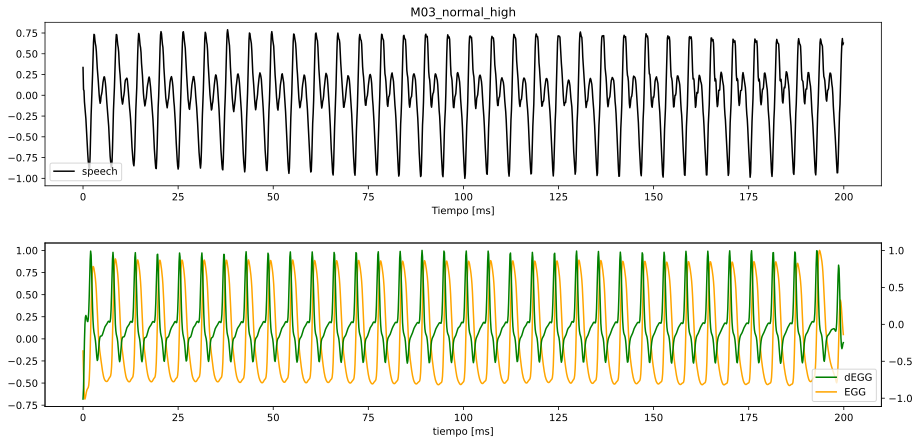

In [3]:
fs_r = 8000
cmap = Funciones.parula_map
color1 = 'red'
color2 = 'blue'
color_EGG = 'orange'
color_dEGG = 'g'
color_energia = 'magenta'
color_speech = 'black'


archivo = "M03_normal_high"

archivo_mic         = 'Repositorio IV/'+archivo+'_mic.wav'
fs_mic,señal_mic = wavfile.read(archivo_mic)

señal_mic   = sig.resample(señal_mic, len(señal_mic)*fs_r//fs_mic)
señal_mic   = [valor/max(np.abs(señal_mic)) for valor in señal_mic]
tiempos = np.arange(0,len(señal_mic)*(1000/fs_r),1000/fs_r)

archivo_EGG      = 'Repositorio IV/'+archivo+'_EGG.wav'
fs_EGG,señal_EGG = wavfile.read(archivo_EGG)
señal_EGG   = sig.resample(señal_EGG, len(señal_EGG)*fs_r//fs_EGG)

# Filtro el EGG con el pasabanda
N    = 2
fci  = 80
fcs  = 1000
b, a = sig.butter(N, [fci,fcs],'bandpass',fs=fs_r)
w, h = sig.freqz(b,a,fs=fs_r)
señal_EGG   = sig.filtfilt(b,a,señal_EGG)
maximo      = max(señal_EGG)
señal_EGG   = [valor/maximo for valor in señal_EGG]

señal_dEGG  = np.gradient(señal_EGG,tiempos)
maximo      = max(señal_dEGG)
señal_dEGG   = [valor/maximo for valor in señal_dEGG]


fig,ax = plt.subplots(2,1,figsize=(15,6))
plt.subplots_adjust(left=None, bottom=None, right=None, top=1, wspace=0.35, hspace=0.35)
ax[0].set_xlabel('Tiempo [ms]')
ax[0].plot(tiempos,señal_mic,color=color_speech,label='speech');
ax[0].set_title(archivo);
ax[0].legend()
ax[1].plot(tiempos,señal_EGG,color=color_EGG);
ax[1].set_xlabel('tiempo [ms]');

ax1_ = ax[1].twinx()
ax1_.plot(tiempos,señal_dEGG,color=color_dEGG,label='dEGG');
ax1_.plot(tiempos[3],señal_EGG[3],color=color_EGG,label="EGG")
ax1_.legend();

In [4]:
# Parámetros para hacer el recorte temporal de la señal
to = 30
tf = 80
no = int(np.round(to *fs_r/1000)) 
nf = int(np.round(tf * fs_r/1000)) 
tiempos       = tiempos[no:nf]

señal_mic    = señal_mic[no:nf]
señal_mic_   = señal_mic
señal_EGG    = señal_EGG[no:nf]
señal_dEGG   = señal_dEGG[no:nf]


In [5]:
# Filtro de pre-énfasis H(z) = 1 - z^-1
b = [1,-1]
a = [1]
señal_mic = sig.lfilter(b,a,señal_mic)


In [6]:
duracion_ventana = 5.5 # En ms
desplazamiento   = 1    
ventana = 'boxcar'
matriz_STFT = Funciones.STFT(señal_mic,ventana,duracion_ventana,desplazamiento,fs_r)

In [7]:
# Me quedo con la mitad+1 de las frecuencias
matriz_STFT          = matriz_STFT[0:matriz_STFT.shape[0]//2+1, :]

# Creo el espectrograma teniendo en cuenta la compresión del paper
p = 0.55
espectrograma =np.abs(matriz_STFT)**p 

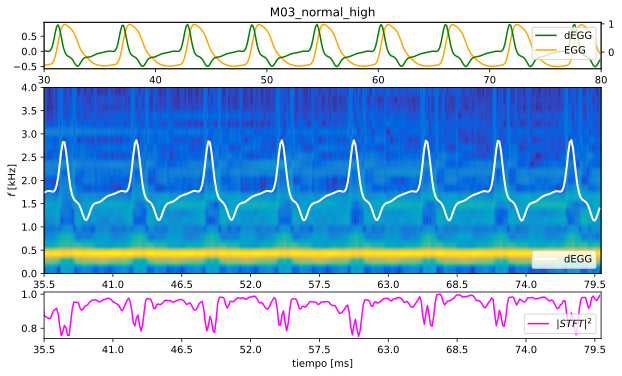

In [8]:
fig,ax = plt.subplots(3,1,figsize=(10,4),gridspec_kw={'height_ratios': [1,4, 1]})
plt.subplots_adjust(left=None, bottom=0.6, right=None, top=1.7, wspace=None, hspace=None)

longitud_ventana = int(np.round(fs_r*duracion_ventana/1000))

to_espec = duracion_ventana+to
tf_espec = tf
fo = 0
ff = fs_r/2000

loc = 'lower right'

ax[0].plot(tiempos,señal_EGG,color=color_EGG);
ax[0].set_xlabel('tiempo [ms]');
ax[0].set_xlim([to,tf]);
ax0_ = ax[0].twinx()
ax0_.plot(tiempos,señal_dEGG,color=color_dEGG,label='dEGG');
ax0_.plot(tiempos[3],señal_EGG[3],color=color_EGG,label="EGG")
ax0_.legend(loc='upper right');
ax0_.set_title(archivo);

ax[1].imshow(espectrograma,cmap = cmap,origin='lower',aspect='auto',extent=[to_espec,tf_espec,fo,ff]);
ax[1].set_xlabel("t [ms]");
ax[1].set_ylabel(r"$f$ [kHz]");
ax1_ = ax[1].twinx()
ax1_.plot(tiempos[longitud_ventana-1:],señal_dEGG[longitud_ventana-1:],color='white',label="dEGG",linewidth=2);
ax1_.legend(loc=loc);
ax1_.set_xticks(np.arange(to_espec,tf_espec,duracion_ventana))
ax1_.set_xlim(to_espec,tf_espec)
ax1_.set_ylim([min(señal_dEGG)-max(señal_dEGG),max(señal_dEGG)+max(señal_dEGG)]);
ax1_.set_yticks([]);


energia = []
for i in range(0,matriz_STFT.shape[1]):
    energia.append(np.sum(np.abs(matriz_STFT[:,i])**2))

maximo = max(energia)
energia = [valor/maximo for valor in energia]
ax[2].plot(tiempos[longitud_ventana-1:],energia,color=color_energia,label=r"$|STFT|^2$");
ax[2].set_xlabel('tiempo [ms]');
ax[2].set_xlim(to_espec,tf_espec)
ax[2].set_xticks(np.arange(to_espec,tf_espec,duracion_ventana))
ax[2].set_xlim([to_espec,tf_espec]);
ax[2].legend(loc=loc);

#fig.savefig('M01_normal_medium_EGG.pdf',bbox_inches = 'tight')


## Prueba de NNMF

### Matriz simple

In [12]:
def NNMF(X,W,H,max_iter,norma='fro',iter_prueba = 15):
    '''
    returns X,W,H,error
    '''
    W_i = W
    H_i = H
    i = 1
    max_i = max_iter
    debajo_error = False

    epsilon = np.finfo(np.float32).eps

    X_aprox = np.matmul(W,H)
    error= []
    error.append(np.linalg.norm(X-X_aprox, ord=norma))
    while i <= iter_prueba:
        H_i = H_i * (np.matmul(W_i.transpose(),X)) /( np.matmul((np.matmul(W_i.transpose(),W_i)),H_i) + epsilon)
        for i_ in range(0,H_i.shape[0]):
            maximo    = np.max(H_i[i_,:])
            H_i[i_,:] = H_i[i_,:]/maximo
        X_aprox =  np.matmul(W_i,H_i)
        error_ = np.linalg.norm(X-X_aprox, ord='fro')
        error.append(error_)
        i+=1
    
    i = 1
    
    while not debajo_error and i <= max_i:

        W_i = W_i * (np.matmul(X,H_i.transpose()))/(np.matmul(W_i,np.matmul(H_i,H_i.transpose())) + epsilon)

        for i_ in range(0,W_i.shape[1]):
            maximo    = np.max(W_i[:,i_])
            W_i[:,i_] = W_i[:,i_]/maximo
        
        H_i = H_i * (np.matmul(W_i.transpose(),X)) /( np.matmul((np.matmul(W_i.transpose(),W_i)),H_i) + epsilon)

        X_aprox =  np.matmul(W_i,H_i)

        error_ = np.linalg.norm(X-X_aprox, ord='fro')
        error.append(error_)

        if error_ <= debajo_error:
            debajo_error = True
            
        i += 1
    return X_aprox,W_i,H_i,error

In [13]:
X = np.array([ 
    [0, 1, 2, 3, 4, 5, 6, 7], 
    [0, 1, 2, 3, 3, 2, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0], 
    [7, 0, 0, 0, 0, 0, 0, 0], 
    [7, 6, 5, 4, 3, 2, 1, 0]    
             ],dtype=float)

N = X.shape[0]
M = X.shape[1]
R = 2

W =  np.random.rand(N,R) 
W = W/np.max(W)
H = np.random.rand(R,M)

max_i = 100
X_aprox,W_,H_,error  = NNMF(X,W,H,max_i)

Traceback (most recent call last):
  File "c:\Users\Emiliano\AppData\Local\Programs\Python\Python312\Lib\site-packages\debugpy\_vendored\pydevd\_pydevd_bundle\pydevd_vars.py", line 624, in change_attr_expression
    value = eval(expression, frame.f_globals, frame.f_locals)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<string>", line 1, in <module>
NameError: name 'array' is not defined. Did you forget to import 'array'
Traceback (most recent call last):
  File "c:\Users\Emiliano\AppData\Local\Programs\Python\Python312\Lib\site-packages\debugpy\_vendored\pydevd\_pydevd_bundle\pydevd_vars.py", line 624, in change_attr_expression
    value = eval(expression, frame.f_globals, frame.f_locals)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<string>", line 1, in <module>
NameError: name 'array' is not defined. Did you forget to import 'array'
Traceback (most recent call last):
  File "c:\Users\Emiliano\AppData\Local\Programs\Python\Python312\Lib

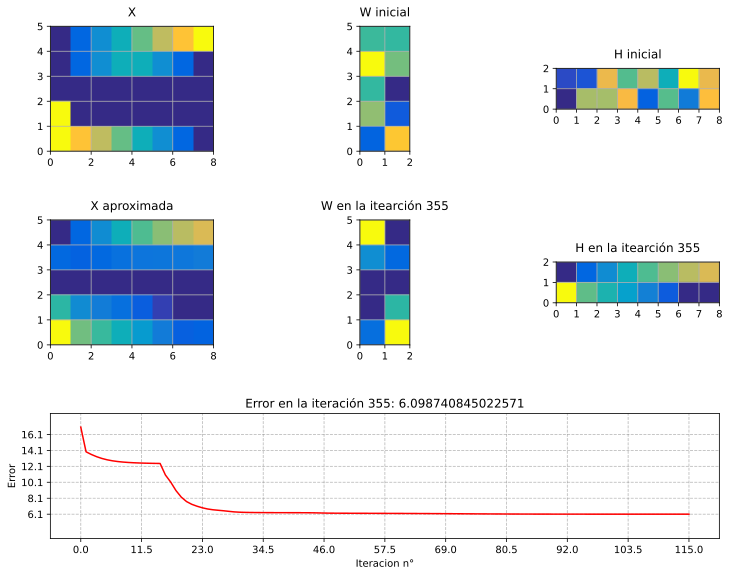

In [14]:

fig = plt.figure(figsize=(12,8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=1, wspace=0.55, hspace=0.55)
gs  = fig.add_gridspec(3,3)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs[1,0])
ax5 = fig.add_subplot(gs[1,1])
ax6 = fig.add_subplot(gs[1,2])
ax7 = fig.add_subplot(gs[2,:])

ax1.imshow(X,aspect='auto',cmap=cmap,extent=[0,M,0,N]);
ax1.grid(True)
ax1.set_yticks(np.arange(0,N+1))
ax1.set_title('X',pad=10)
ax2.imshow(W,aspect='equal',cmap=cmap,extent=[0,R,0,N]);
ax2.grid(True)
ax2.set_yticks(np.arange(0,N+1))
ax2.set_xticks(np.arange(0,R+1))
ax2.set_title('W inicial',pad=10)
ax3.imshow(H,aspect='equal',cmap=cmap,extent=[0,M,0,R]);
ax3.grid(True)
ax3.set_yticks(np.arange(0,R+1))
ax3.set_xticks(np.arange(0,M+1));
ax3.set_title('H inicial',pad=10);

ax4.imshow(X_aprox,aspect='auto',cmap=cmap,extent=[0,M,0,N]);
ax4.grid(True)
ax4.set_yticks(np.arange(0,N+1))
ax4.set_title('X aproximada',pad=10)
ax5.imshow(W_,aspect='equal',cmap=cmap,extent=[0,R,0,N]);
ax5.grid(True)
ax5.set_yticks(np.arange(0,N+1))
ax5.set_xticks(np.arange(0,R+1))
ax5.set_title('W en la itearción '+str(i-1),pad=10)
ax6.imshow(H_,aspect='equal',cmap=cmap,extent=[0,M,0,R]);
ax6.grid(True)
ax6.set_yticks(np.arange(0,R+1))
ax6.set_xticks(np.arange(0,M+1));
ax6.set_title('H en la itearción '+str(i-1),pad=10);

iteraciones = np.arange(0,len(error))
ax7.plot(iteraciones,error,linewidth=1.5,color='red')
ax7.set_xlabel('Iteracion n°')
ax7.set_xticks(np.arange(0,iteraciones[-1]+10,iteraciones[-1]/10))
ax7.set_ylabel('Error')
ax7.set_ylim([min(error)*0.5,max(error)*1.1])
ax7.set_yticks(np.arange(error[-1],error[0],round(error[0]/10)))
ax7.grid(True,linestyle='dashed',color='gray',alpha=0.55);
ax7.set_title('Error en la iteración '+str(i-1)+': '+str(error[-1]));

### Prueba sobre la señal

In [15]:
indice_maximo = np.where(energia == max(energia))[0][0]
indice_minimo = np.where(energia == min(energia))[0][0]
X = espectrograma
N = X.shape[0]
M = X.shape[1]
R = 2


W = np.array([np.array(espectrograma[:,indice_maximo]),np.array(espectrograma[:,indice_minimo])]).transpose()
H = np.random.rand(R, M)
max_i = 50
X_aprox,W_i,H_i,error = Funciones.NNMF(X,W,H,max_i)

In [16]:
len(error)

66

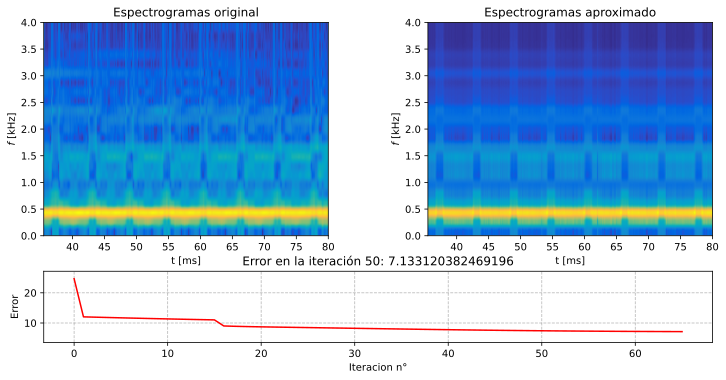

In [17]:
fig = plt.figure(figsize=(12,5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=1, wspace=0.35, hspace=0.25)
gs  = fig.add_gridspec(2,2,height_ratios=[3, 1])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,:])

ax1.imshow(espectrograma,cmap = cmap,origin='lower',aspect='auto',extent=[to_espec,tf_espec,fo,ff]);
ax1.set_xlabel("t [ms]");
ax1.set_ylabel(r"$f$ [kHz]");
ax1.set_title('Espectrogramas original')
ax2.imshow(X_aprox,cmap = cmap,origin='lower',aspect='auto',extent=[to_espec,tf_espec,fo,ff]);
ax2.set_xlabel("t [ms]");
ax2.set_ylabel(r"$f$ [kHz]");
ax2.set_title('Espectrogramas aproximado')

iteraciones = np.arange(0,len(error))
ax3.plot(iteraciones,error,linewidth=1.5,color='red')
ax3.set_xlabel('Iteracion n°')
#ax3.set_xticks(np.arange(0,iteraciones[-1]+10,iteraciones[-1]/10))
ax3.set_ylabel('Error')
ax3.set_ylim([min(error)*0.5,max(error)*1.1])
#ax3.set_yticks(np.arange(error[-1],error[0],round(error[0]/25)))
ax3.grid(True,linestyle='dashed',color='gray',alpha=0.55);
ax3.set_title('Error en la iteración '+str(max_i)+': '+str(error[-1]));


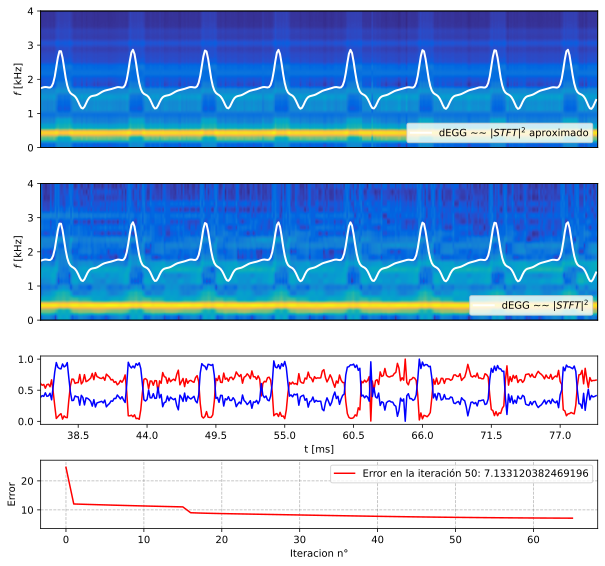

In [20]:
H1 = np.array(H_i[0,:])/max(H_i[0,:])
H2 = np.array(H_i[1,:])/max(H_i[1,:])


fig,ax = plt.subplots(4,1,figsize=(10,6),gridspec_kw={'height_ratios': [1,1, 0.5,0.5]})
plt.subplots_adjust(left=None, bottom=0.5, right=None, top=1.7, wspace=None, hspace=0.35)

ax[0].imshow(X_aprox,cmap = cmap,origin='lower',aspect='auto',extent=[to_espec,tf_espec,fo,ff]);
ax[0].set_ylabel(r"$f$ [kHz]");
ax[0].set_xticks([]);
ax0_ = ax[0].twinx()
ax0_.plot(tiempos[longitud_ventana-1:],señal_dEGG[longitud_ventana-1:],color='white',label=r"dEGG ~~ $|STFT|^2$ aproximado",linewidth=2);
ax0_.legend(loc=loc);
ax0_.set_xlim(to_espec,tf_espec)
ax0_.set_ylim([min(señal_dEGG)-max(señal_dEGG),max(señal_dEGG)+max(señal_dEGG)]);
ax0_.set_yticks([]);
ax0_.set_xticks([]);


ax[1].imshow(espectrograma,cmap = cmap,origin='lower',aspect='auto',extent=[to_espec,tf_espec,fo,ff]);
ax[1].set_ylabel(r"$f$ [kHz]");
ax1_ = ax[1].twinx()
ax1_.plot(tiempos[longitud_ventana-1:],señal_dEGG[longitud_ventana-1:],color='white',label=r"dEGG ~~ $|STFT|^2$",linewidth=2);
ax1_.legend(loc=loc);
ax1_.set_xlim(to_espec,tf_espec)
ax1_.set_ylim([min(señal_dEGG)-max(señal_dEGG),max(señal_dEGG)+max(señal_dEGG)]);
ax1_.set_yticks([]);
ax1_.set_xticks([]);

ax[2].plot(tiempos[longitud_ventana-1:],H1,color=color1)
ax[2].plot(tiempos[longitud_ventana-1:],H2,color=color2)
ax[2].set_xticks(np.arange(duracion_ventana,tf_espec,duracion_ventana))
ax[2].set_xlim(to_espec,tf_espec);
ax[2].set_xlabel("t [ms]");

iteraciones = np.arange(0,len(error))
ax[3].plot(iteraciones,error,linewidth=1.5,color='red',label= 'Error en la iteración '+str(max_i)+': '+str(error[-1]))
ax[3].set_xlabel('Iteracion n°')
ax[3].set_ylabel('Error')
ax[3].set_ylim([min(error)*0.5,max(error)*1.1])
ax[3].grid(True,linestyle='dashed',color='gray',alpha=0.55);
ax[3].legend();
#fig.savefig('NNMF/caso3.pdf',bbox_inches = 'tight');

##### Autocorrelación

In [21]:
W1 = W_i[:,0]
W2 = W_i[:,1]

In [22]:
W1 = W1**(2/p)
W2 = W2**(2/p)


In [23]:
W1_ =np.concatenate((W1,np.flip(W1)[1:-1]))
W2_ =np.concatenate((W2,np.flip(W2)[1:-1]))


In [24]:
r_W1 = np.fft.ifft(W1_).real
r_W2 = np.fft.ifft(W2_).real

##### Levinson-Durbin

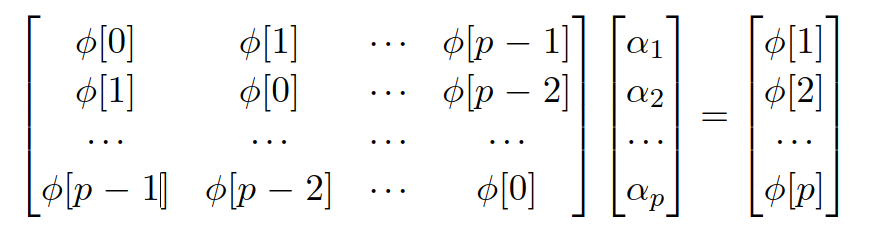

In [25]:
orden = 12

a_   = solve_toeplitz((r_W1[0:orden-1], r_W1[0:orden-1]), r_W1[1:orden])
a_W1 = np.concatenate(([1.0], -a_))

a_ = solve_toeplitz((r_W2[0:orden-1], r_W2[0:orden-1]), r_W2[1:orden])
a_W2 = np.concatenate(([1.0], -a_))


##### Filtrado inverso

$
\begin{align}
S(z) &= G(z)L(z)V(z)\\[0.5cm]
G(z) &=S(z)\,\frac{1}{L(z)V(z)}
\end{align}
$

> $
L(z) = 1-\alpha\,z^{-1}
$

> $
\displaystyle V(z) = \frac{1}{1-\sum_{k=1}^p a_k\,z^{-1}}
$

$
\begin{align}
G(z) &=S(z)\,\frac{1-\sum_{k=1}^p a_k\,z^{-1}}{1-\alpha\,z^{-1}}
\end{align}
$

In [26]:
alfa = 1
flujo_w1 = sig.lfilter(a_W1,[1,-alfa],señal_mic_)


flujo_w1 = [val/max(abs(flujo_w1)) for val in flujo_w1]

flujo_w2 = sig.lfilter(a_W2,[1,-alfa],señal_mic_)

flujo_w2 = [val/max(abs(flujo_w2)) for val in flujo_w2]

##### Plots

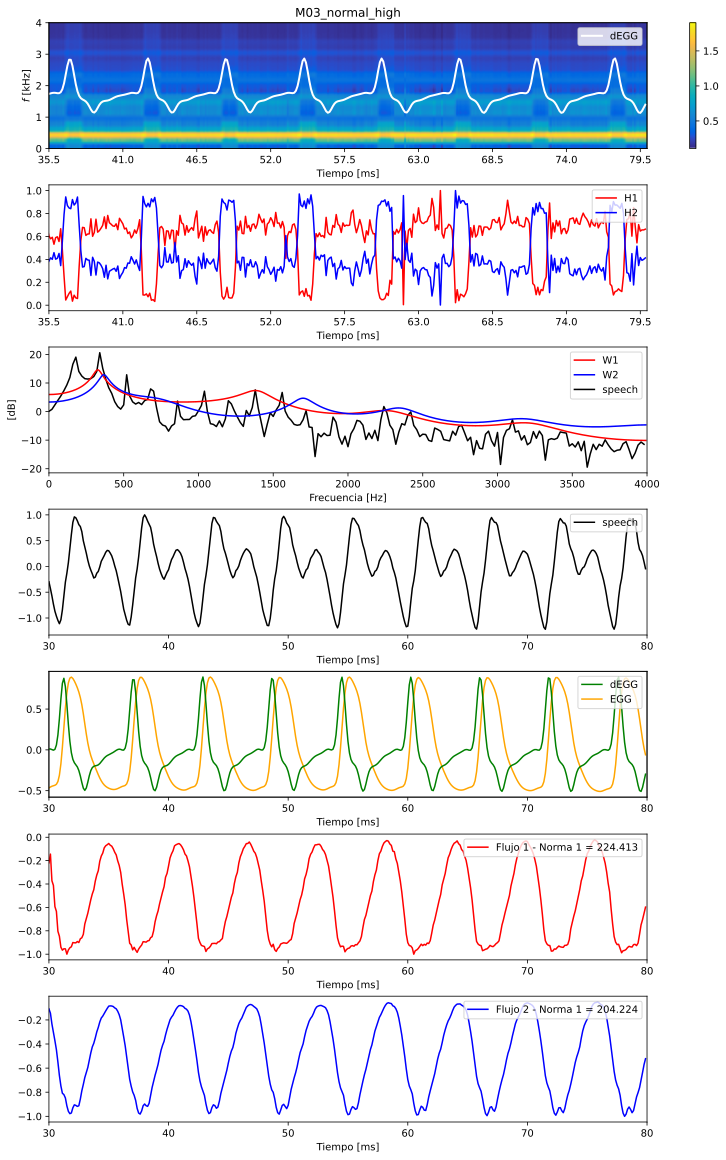

In [28]:
fig,ax=plt.subplots(7,1,figsize=(10,16),layout='constrained')
#plt.subplots_adjust(left=None, bottom=None, right=None, top=1, wspace=0.35, hspace=0.35)

señal_mic_ = [val/max(señal_mic_) for val in señal_mic_]
fw1,hw1 = sig.freqz([1],a_W1,fs=fs_r)
fw2,hw2 = sig.freqz([1],a_W2,fs=fs_r)

color1 = 'red'
color2 = 'blue'


fftseñal,fseñal = Funciones.FFT(señal_mic_,fs_r)

espect = ax[0].imshow(X_aprox,cmap = cmap,origin='lower',aspect='auto',extent=[to_espec,tf_espec,fo,ff]);
ax[0].set_ylabel(r"$f$ [kHz]");
ax[0].set_xticks([]);
ax[0].set_title(archivo)
fig.colorbar(espect, ax=ax[0])

ax0_ = ax[0].twinx()
ax0_.plot(tiempos[longitud_ventana-1:],señal_dEGG[longitud_ventana-1:],color='white',label="dEGG",linewidth=2);
ax0_.legend(loc='upper right');
ax0_.set_xlim(to_espec,tf_espec)
ax0_.set_ylim([min(señal_dEGG)-max(señal_dEGG),max(señal_dEGG)+max(señal_dEGG)]);
ax0_.set_xticks(np.arange(to_espec,tf_espec,duracion_ventana))
ax0_.set_yticks([]);

ax[0].set_xlabel('Tiempo [ms]');

ax[1].plot(tiempos[longitud_ventana-1:],H1,color=color1,label='H1')
ax[1].plot(tiempos[longitud_ventana-1:],H2,color=color2,label='H2')
ax[1].set_xticks(np.arange(to_espec,tf_espec,duracion_ventana))
ax[1].set_xlim(to_espec,tf_espec);
ax[1].legend(loc='upper right');
ax[1].set_xlabel('Tiempo [ms]');

ax[2].plot(fw1,10*np.log10(np.abs(hw1)),label='W1',color=color1)
ax[2].plot(fw2,10*np.log10(np.abs(hw2)),label='W2',color=color2)
ax[2].plot(fseñal,10*np.log10(np.abs(fftseñal)),label='speech',color=color_speech,zorder=-1)
ax[2].set_xlim(0,fs_r/2);
ax[2].set_xlabel('Frecuencia [Hz]');
ax[2].set_ylabel('[dB]');
ax[2].legend(loc='upper right');

ax[3].plot(tiempos,señal_mic_,color=color_speech,label='speech');
ax[3].set_xlim([to,tf]);
ax[3].legend(loc='upper right');
ax[3].set_xlabel('Tiempo [ms]');

ax[4].plot(tiempos,señal_EGG,color=color_EGG);
ax[4].set_xlim([to,tf]);
ax1_ = ax[4].twinx()
ax1_.plot(tiempos,señal_dEGG,color=color_dEGG,label='dEGG');
ax1_.plot(tiempos[3],señal_EGG[3],color=color_EGG,label="EGG")
ax1_.legend(loc='upper right');
ax1_.set_yticks([])
ax[4].set_xlabel('Tiempo [ms]');

ax[5].plot(tiempos,flujo_w1,color=color1,label='Flujo 1 - Norma 1 = '+str(round(np.linalg.norm(flujo_w1,ord=1),3)))
ax[5].set_xlim([to,tf]);
ax[5].legend(loc='upper right');
ax[5].set_xlabel('Tiempo [ms]');

ax[6].plot(tiempos,flujo_w2,color=color2,label='Flujo 2 - Norma 1 = '+str(round(np.linalg.norm(flujo_w2,ord=1),3)))
ax[6].set_xlabel('Tiempo [ms]');
ax[6].set_xlim([to,tf]);
ax[6].legend(loc='upper right');
ax[6].set_xlabel('Tiempo [ms]');

#fig.savefig("Prueba NNMF/"+archivo+'.pdf',bbox_inches = 'tight')


### TODO

> Comparar el desempeño del procedimiento actual a partir de las señales del repositorio 2.
>

# Prueba con repositorio II

In [1]:
import numpy as np
from scipy.io import wavfile
import IPython.display as ipd
from scipy import signal as sig
from scipy.linalg import solve_toeplitz
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

import Funciones as Funciones
from NNMF_GIF import NNMF_GIF
from MetricasRendimiento import MetricasRendimiento
from PyPDF2 import PdfMerger

## Carga de la señal

In [2]:
archivo = "Male_A_82Hz_small"
fs_r = 8000
cmap = Funciones.parula_map
color_flujo = 'blue'
color_dflujo = 'red'
color_area = 'orange'
color_darea = 'g'
color_energia = 'magenta'
color_speech = 'black'
legend_loc = 'upper right'

In [3]:
señales       = np.loadtxt("Señales Repositorio II Resampleadas/"+archivo+".txt", delimiter="\t")
tiempos_      = señales[:, 0]
señal_speech_ = señales[:, 1]
señal_flujo_  = señales[:, 2]
señal_dflujo_ = señales[:, 3]
señal_area_   = señales[:, 4]
señal_darea_  = señales[:, 5]

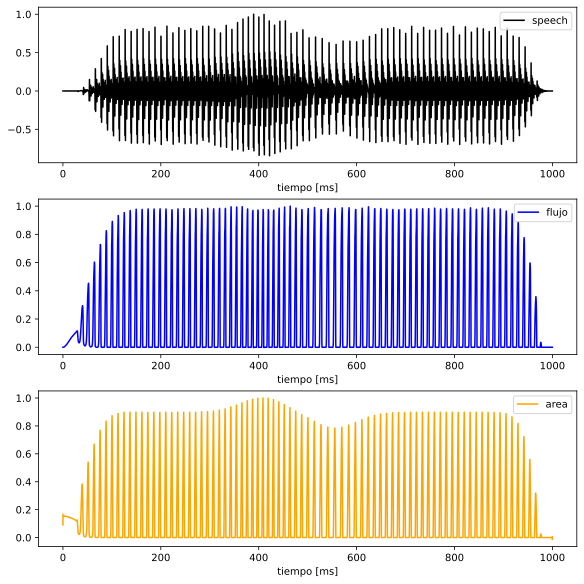

In [4]:
fig,ax = plt.subplots(3,1,figsize=(8,8),layout='constrained')
ax[0].plot(tiempos_,señal_speech_,label='speech',color=color_speech)
ax[1].plot(tiempos_,señal_flujo_,label='flujo',color=color_flujo)
ax[2].plot(tiempos_,señal_area_,label='area',color=color_area);

for ax_ in ax:
    ax_.legend(loc=legend_loc);
    ax_.set_xlabel('tiempo [ms]')

In [5]:
to = 750
tf = 800
no = int(np.round(to *fs_r/1000)) 
nf = int(np.round(tf * fs_r/1000))
tiempos       = tiempos_[no:nf]

señal_speech  = señal_speech_[no:nf]
señal_flujo   = señal_flujo_[no:nf]
señal_dflujo   = señal_dflujo_[no:nf]
señal_area    = señal_area_[no:nf]
señal_darea   = señal_darea_[no:nf]


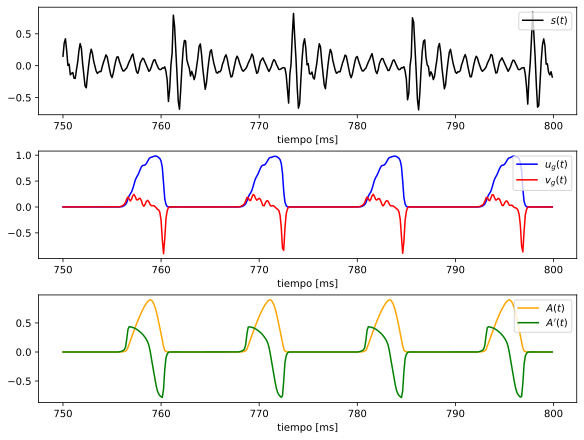

In [6]:
fig,ax = plt.subplots(3,1,figsize=(8,6),layout='constrained')
ax[0].plot(tiempos,señal_speech,label=r'$s(t)$',color=color_speech)
ax[1].plot(tiempos,señal_flujo,label=r'$u_g(t)$',color=color_flujo)
ax[1].plot(tiempos,señal_dflujo,label=r'$v_g(t)$',color=color_dflujo)
ax[2].plot(tiempos,señal_area,label=r'$A(t)$',color=color_area)
ax[2].plot(tiempos,señal_darea,label=r"$A'(t)$",color=color_darea)
for ax_ in ax:
    ax_.legend(loc=legend_loc);
    ax_.set_xlabel('tiempo [ms]')   

## Algoritmo

### Graficación 1

In [7]:
SP1 = NNMF_GIF(señal_speech,tiempos,fs_r)

In [8]:
MR1 = MetricasRendimiento(señal_dflujo,Funciones.Sincronizar(SP1.dflujo1,señal_dflujo),fs_r,tiempos)
MR2 = MetricasRendimiento(señal_dflujo,Funciones.Sincronizar(SP1.dflujo2,señal_dflujo),fs_r,tiempos)

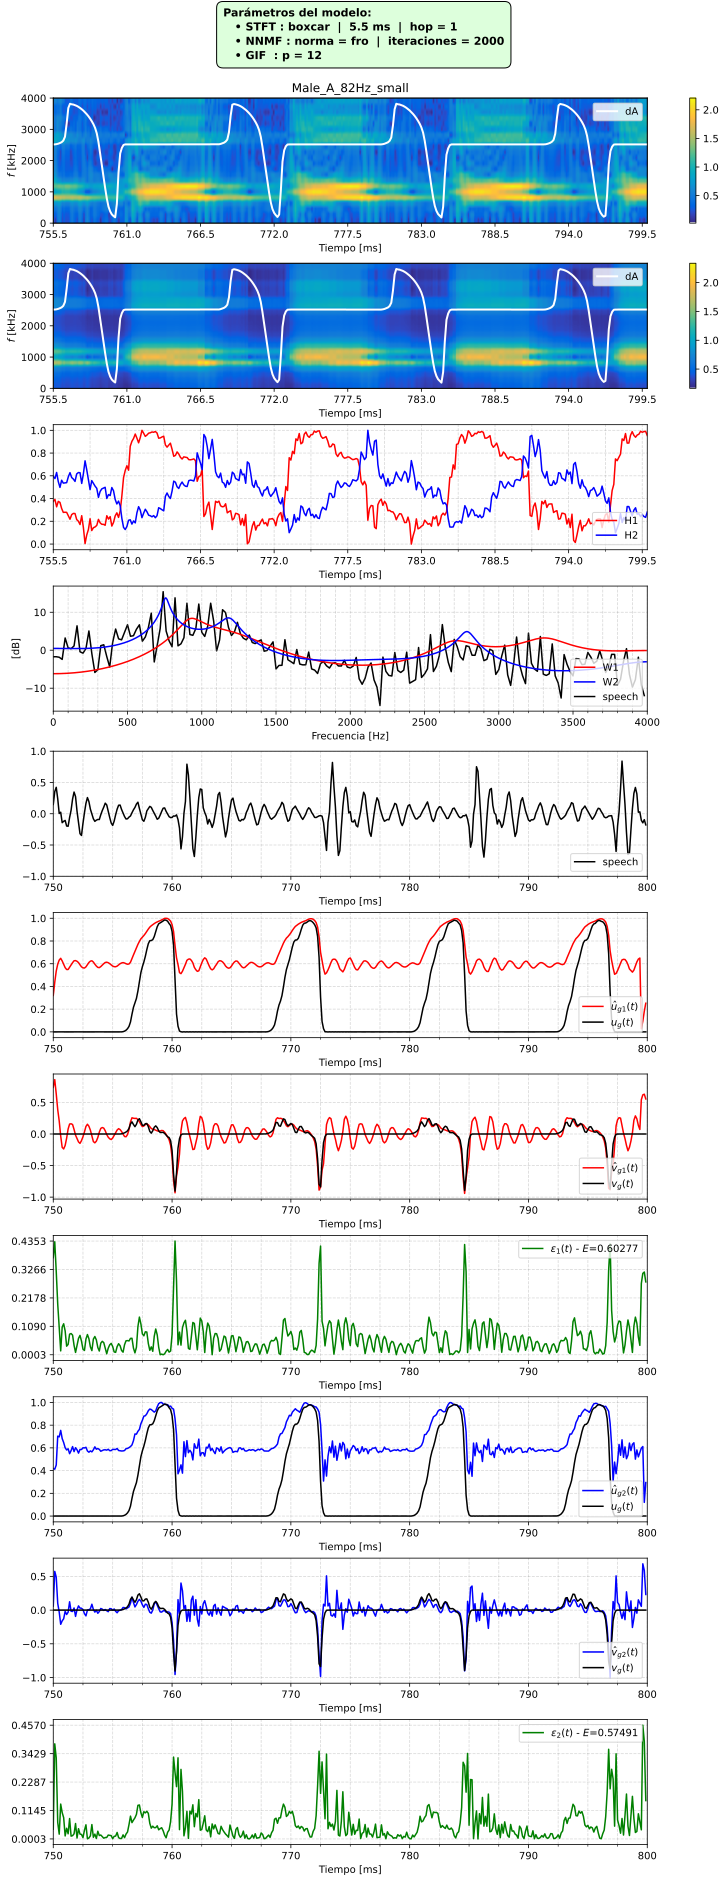

In [9]:
fig,ax=plt.subplots(11,1,figsize=(10,25),layout='constrained')
#plt.subplots_adjust(left=None, bottom=None, right=None, top=1, wspace=0.35, hspace=0.35)
fw1,hw1 = sig.freqz([1],SP1.a_W1,fs=fs_r)
fw2,hw2 = sig.freqz([1],SP1.a_W2,fs=fs_r)

color1 = 'red'
color2 = 'blue'
color_error = 'green'
loc = 'lower right'
fftseñal,fseñal = Funciones.FFT(señal_speech,fs_r)

espect = ax[0].imshow(SP1.espectrograma,cmap = cmap,origin='lower',aspect='auto',extent=[SP1.to_espec,SP1.tf_espec,SP1.fo_espec,SP1.ff_espec]);
ax[0].set_ylabel(r"$f$ [kHz]");
ax[0].set_title(archivo)
fig.colorbar(espect, ax=ax[0])


ax0_ = ax[0].twinx()
ax0_.plot(tiempos[SP1.long_ventana_espect-1:],señal_darea[SP1.long_ventana_espect-1:],color='white',label="dA",linewidth=2);
ax0_.legend(loc='upper right');
ax0_.set_xlim(SP1.to_espec,SP1.tf_espec)
ax0_.set_xticks(np.arange(SP1.to_espec,SP1.tf_espec,SP1.duracion_ventana))
ax0_.set_yticks([])
ax[0].set_xlabel('Tiempo [ms]');

espect = ax[1].imshow(SP1.espectrograma_aprox,cmap = cmap,origin='lower',aspect='auto',extent=[SP1.to_espec,SP1.tf_espec,SP1.fo_espec,SP1.ff_espec]);
ax[1].set_ylabel(r"$f$ [kHz]");
fig.colorbar(espect, ax=ax[1])

ax1_ = ax[1].twinx()
ax1_.plot(tiempos[SP1.long_ventana_espect:],señal_darea[SP1.long_ventana_espect:],color='white',label="dA",linewidth=2);
ax1_.legend(loc='upper right');
ax1_.set_xlim(SP1.to_espec,SP1.tf_espec)
ax1_.set_xticks(np.arange(SP1.to_espec,SP1.tf_espec,SP1.duracion_ventana))
ax1_.set_yticks([])
ax[1].set_xlabel('Tiempo [ms]');


ax[2].plot(SP1.tiempos[SP1.long_ventana_espect-1:],SP1.H1,color=color1,label='H1')
ax[2].plot(SP1.tiempos[SP1.long_ventana_espect-1:],SP1.H2,color=color2,label='H2')
ax[2].set_xlim(SP1.to_espec,SP1.tf_espec)
ax[2].set_xticks(np.arange(SP1.to_espec,SP1.tf_espec,SP1.duracion_ventana))
ax[2].set_xticks(np.arange(SP1.to_espec,SP1.tf_espec,SP1.duracion_ventana/2),minor=True)
ax[2].grid(True,linestyle='dashed',color='gray',alpha=0.3,which='both')
ax[2].legend(loc=loc);
ax[2].set_xlabel('Tiempo [ms]');

ax[3].plot(fw1,10*np.log10(np.abs(hw1)),label='W1',color=color1)
ax[3].plot(fw2,10*np.log10(np.abs(hw2)),label='W2',color=color2)
ax[3].plot(fseñal,10*np.log10(np.abs(fftseñal)),label='speech',color=color_speech,zorder=-1)
ax[3].set_xlim(0,fs_r/2);
ax[3].set_xticks(np.arange(0,fs_r/2,100),minor=True)
ax[3].grid(True,linestyle='dashed',color='gray',alpha=0.3,which='both')
ax[3].set_xlabel('Frecuencia [Hz]');
ax[3].set_ylabel('[dB]');
ax[3].legend(loc=loc);

ax[4].plot(tiempos,señal_speech,color=color_speech,label='speech');
ax[4].set_xlim([to,tf]);
ax[4].set_xticks(np.arange(to,tf,2.5),minor=True)
ax[4].grid(True,linestyle='dashed',color='gray',alpha=0.3,which='both')
ax[4].legend(loc=loc);
ax[4].set_xlabel('Tiempo [ms]');
ax[4].set_ylim(-1,1)

ax[5].plot(tiempos,Funciones.Sincronizar(SP1.flujo1,señal_flujo),color=color1,label=r'$\hat{u}_{g1}(t)$');
ax[5].plot(tiempos,señal_flujo,color=color_speech,label=r'$u_g(t)$');
ax[5].set_xlim([to,tf]);
ax[5].set_xticks(np.arange(to,tf,2.5),minor=True)
ax[5].grid(True,linestyle='dashed',color='gray',alpha=0.3,which='both')
ax[5].legend(loc=loc);
ax[5].set_xlabel('Tiempo [ms]');



ax[6].plot(tiempos,Funciones.Sincronizar(SP1.dflujo1,señal_dflujo),color=color1,label=r'$\hat{v}_{g1}(t)$');
ax[6].plot(tiempos,señal_dflujo,color=color_speech,label=r'$v_g(t)$');
ax[6].set_xlim([to,tf]);
ax[6].set_xticks(np.arange(to,tf,2.5),minor=True)
ax[6].grid(True,linestyle='dashed',color='gray',alpha=0.3,which='both')
ax[6].legend(loc=loc);
ax[6].set_xlabel('Tiempo [ms]');

ax[7].plot(tiempos,MR1.Curva_error,color=color_error,label=r'$\varepsilon_1(t)$'+str(' - ')+r'$E$={}'.format(round(MR1.Error,5)));
ax[7].set_xlim([to,tf]);
ax[7].set_xticks(np.arange(to,tf,2.5),minor=True)
ax[7].grid(True,linestyle='dashed',color='gray',alpha=0.3,which='both')
ax[7].legend(loc='upper right');
ax[7].set_xlabel('Tiempo [ms]');
ax[7].set_yticks(np.linspace(min(MR1.Curva_error),max(MR1.Curva_error),5))
ax[7].grid(True,linestyle='dashed',color='gray',alpha=0.3)


ax[8].plot(tiempos,Funciones.Sincronizar(SP1.flujo2,señal_flujo),color=color2,label=r'$\hat{u}_{g2}(t)$');
ax[8].plot(tiempos,señal_flujo,color=color_speech,label=r'$u_g(t)$');
ax[8].set_xlim([to,tf]);
ax[8].set_xticks(np.arange(to,tf,2.5),minor=True)
ax[8].grid(True,linestyle='dashed',color='gray',alpha=0.3,which='both')
ax[8].legend(loc=loc);
ax[8].set_xlabel('Tiempo [ms]');


ax[9].plot(tiempos,Funciones.Sincronizar(SP1.dflujo2,señal_dflujo),color=color2,label=r'$\hat{v}_{g2}(t)$');
ax[9].plot(tiempos,señal_dflujo,color=color_speech,label=r'$v_g(t)$');
ax[9].set_xlim([to,tf]);
ax[9].set_xticks(np.arange(to,tf,2.5),minor=True)
ax[9].grid(True,linestyle='dashed',color='gray',alpha=0.3,which='both')
ax[9].legend(loc=loc);
ax[9].set_xlabel('Tiempo [ms]');

ax[10].plot(tiempos,MR2.Curva_error,color=color_error,label=r'$\varepsilon_2(t) $'+str(' - ')+r'$E$={}'.format(round(MR2.Error,5)));
ax[10].set_xlim([to,tf]);
ax[10].set_xticks(np.arange(to,tf,2.5),minor=True)
ax[10].grid(True,linestyle='dashed',color='gray',alpha=0.3,which='both')
ax[10].legend(loc='upper right');
ax[10].set_xlabel('Tiempo [ms]');
ax[10].set_yticks(np.linspace(min(MR2.Curva_error),max(MR2.Curva_error),5))
ax[10].grid(True,linestyle='dashed',color='gray',alpha=0.3)

fig.text(
    0.5, 1.04,  # centrado horizontalmente respecto a la figura
    f"Parámetros del modelo:\n"
    f"   • STFT : {SP1.ventana}  |  {SP1.duracion_ventana:.1f} ms  |  hop = {SP1.desplazamiento}\n"
    f"   • NNMF : norma = {SP1.norma}  |  iteraciones = {SP1.max_iter}\n"
    f"   • GIF  : p = {SP1.orden_filtro_tracto}",
    ha='center', va='top',                 # centra el recuadro
    multialignment='left',                 # alinea el texto la izquierda
    fontsize=11, fontweight='bold',
    linespacing=1.4,
    bbox=dict(facecolor=(0.867, 1, 0.863), edgecolor='black', boxstyle='round,pad=0.6')
);
#fig.savefig("Prueba Repositorio II/"+archivo+'.pdf',bbox_inches = 'tight')

### Graficación 2

In [ ]:
SP1 = NNMF_GIF(señal_speech,tiempos,fs_r)

In [ ]:
MR1 = MetricasRendimiento(señal_dflujo,Funciones.Sincronizar(SP1.dflujo1,señal_dflujo),fs_r,tiempos)
MR2 = MetricasRendimiento(señal_dflujo,Funciones.Sincronizar(SP1.dflujo2,señal_dflujo),fs_r,tiempos)

In [ ]:
fig,ax=plt.subplots(8,1,figsize=(10,25),layout='constrained')
#plt.subplots_adjust(left=None, bottom=None, right=None, top=1, wspace=0.35, hspace=0.35)
fw1,hw1 = sig.freqz([1],SP1.a_W1,fs=fs_r)
fw2,hw2 = sig.freqz([1],SP1.a_W2,fs=fs_r)

color1 = 'red'
color2 = 'blue'
color_error = 'green'
loc = 'lower right'
fftseñal,fseñal = Funciones.FFT(señal_speech,fs_r)

espect = ax[0].imshow(SP1.espectrograma,cmap = cmap,origin='lower',aspect='auto',extent=[SP1.to_espec,SP1.tf_espec,SP1.fo_espec,SP1.ff_espec]);
ax[0].set_ylabel(r"$f$ [kHz]");
ax[0].set_title(archivo)
fig.colorbar(espect, ax=ax[0])


ax0_ = ax[0].twinx()
ax0_.plot(tiempos[SP1.long_ventana_espect-1:],señal_darea[SP1.long_ventana_espect-1:],color='white',label="dA",linewidth=2);
ax0_.legend(loc='upper right');
ax0_.set_xlim(SP1.to_espec,SP1.tf_espec)
ax0_.set_xticks(np.arange(SP1.to_espec,SP1.tf_espec,SP1.duracion_ventana))
ax0_.set_yticks([])
ax[0].set_xlabel('Tiempo [ms]');

espect = ax[1].imshow(SP1.espectrograma_aprox,cmap = cmap,origin='lower',aspect='auto',extent=[SP1.to_espec,SP1.tf_espec,SP1.fo_espec,SP1.ff_espec]);
ax[1].set_ylabel(r"$f$ [kHz]");
fig.colorbar(espect, ax=ax[1])

ax1_ = ax[1].twinx()
ax1_.plot(tiempos[SP1.long_ventana_espect:],señal_darea[SP1.long_ventana_espect:],color='white',label="dA",linewidth=2);
ax1_.legend(loc='upper right');
ax1_.set_xlim(SP1.to_espec,SP1.tf_espec)
ax1_.set_xticks(np.arange(SP1.to_espec,SP1.tf_espec,SP1.duracion_ventana))
ax1_.set_yticks([])
ax[1].set_xlabel('Tiempo [ms]');


ax[2].plot(SP1.tiempos[SP1.long_ventana_espect-1:],SP1.H1,color=color1,label='H1')
ax[2].plot(SP1.tiempos[SP1.long_ventana_espect-1:],SP1.H2,color=color2,label='H2')
ax[2].set_xlim(SP1.to_espec,SP1.tf_espec)
ax[2].set_xticks(np.arange(SP1.to_espec,SP1.tf_espec,SP1.duracion_ventana))
ax[2].set_xticks(np.arange(SP1.to_espec,SP1.tf_espec,SP1.duracion_ventana/2),minor=True)
ax[2].grid(True,linestyle='dashed',color='gray',alpha=0.3,which='both')
ax[2].legend(loc=loc);
ax[2].set_xlabel('Tiempo [ms]');

ax[3].plot(fw1,10*np.log10(np.abs(hw1)),label='W1',color=color1)
ax[3].plot(fw2,10*np.log10(np.abs(hw2)),label='W2',color=color2)
ax[3].plot(fseñal,10*np.log10(np.abs(fftseñal)),label='speech',color=color_speech,zorder=-1)
ax[3].set_xlim(0,fs_r/2);
ax[3].set_xticks(np.arange(0,fs_r/2,100),minor=True)
ax[3].grid(True,linestyle='dashed',color='gray',alpha=0.3,which='both')
ax[3].set_xlabel('Frecuencia [Hz]');
ax[3].set_ylabel('[dB]');
ax[3].legend(loc=loc);

ax[4].plot(tiempos,señal_speech,color=color_speech,label='speech');
ax[4].set_xlim([to,tf]);
ax[4].set_xticks(np.arange(to,tf,2.5),minor=True)
ax[4].grid(True,linestyle='dashed',color='gray',alpha=0.3,which='both')
ax[4].legend(loc=loc);
ax[4].set_xlabel('Tiempo [ms]');
ax[4].set_ylim(-1,1)

ax[5].plot(tiempos,Funciones.Sincronizar(SP1.flujo1,señal_flujo),color=color1,label=r'$\hat{u}_{g1}(t)$');
ax[5].plot(tiempos,señal_flujo,color=color_speech,label=r'$u_g(t)$');
ax[5].plot(tiempos,Funciones.Sincronizar(SP1.flujo2,señal_flujo),color=color2,label=r'$\hat{u}_{g2}(t)$');
ax[5].set_xlim([to,tf]);
ax[5].set_xticks(np.arange(to,tf,2.5),minor=True)
ax[5].grid(True,linestyle='dashed',color='gray',alpha=0.3,which='both')
ax[5].legend(loc=loc);
ax[5].set_xlabel('Tiempo [ms]');



ax[6].plot(tiempos,Funciones.Sincronizar(SP1.dflujo1,señal_dflujo),color=color1,label=r'$\hat{v}_{g1}(t)$');
ax[6].plot(tiempos,Funciones.Sincronizar(SP1.dflujo2,señal_dflujo),color=color2,label=r'$\hat{v}_{g2}(t)$');
ax[6].plot(tiempos,señal_dflujo,color=color_speech,label=r'$v_g(t)$');
ax[6].set_xlim([to,tf]);
ax[6].set_xticks(np.arange(to,tf,2.5),minor=True)
ax[6].grid(True,linestyle='dashed',color='gray',alpha=0.3,which='both')
ax[6].legend(loc=loc);
ax[6].set_xlabel('Tiempo [ms]');

ax[7].plot(tiempos,MR1.Curva_error,color=color1,label=r'$\varepsilon_1(t)$'+str(' - ')+r'$E$={}'.format(round(MR1.Error,5)));
ax[7].plot(tiempos,MR2.Curva_error,color=color2,label=r'$\varepsilon_2(t) $'+str(' - ')+r'$E$={}'.format(round(MR2.Error,5)));
ax[7].set_xlim([to,tf]);
ax[7].set_xticks(np.arange(to,tf,2.5),minor=True)
ax[7].grid(True,linestyle='dashed',color='gray',alpha=0.3,which='both')
ax[7].legend(loc='upper right');
ax[7].set_xlabel('Tiempo [ms]');
ax[7].set_yticks(np.linspace(min(MR1.Curva_error),max(MR1.Curva_error),5))
ax[7].grid(True,linestyle='dashed',color='gray',alpha=0.3)


fig.text(
    0.5, 1.04,  # centrado horizontalmente respecto a la figura
    f"Parámetros del modelo:\n"
    f"   • STFT : {SP1.ventana}  |  {SP1.duracion_ventana:.1f} ms  |  hop = {SP1.desplazamiento}\n"
    f"   • NNMF : norma = {SP1.norma}  |  iteraciones = {SP1.max_iter}\n"
    f"   • GIF  : p = {SP1.orden_filtro_tracto}",
    ha='center', va='top',                 # centra el recuadro
    multialignment='left',                 # alinea el texto la izquierda
    fontsize=11, fontweight='bold',
    linespacing=1.4,
    bbox=dict(facecolor=(0.867, 1, 0.863), edgecolor='black', boxstyle='round,pad=0.6')
);
fig.savefig("Prueba Repositorio II/"+archivo+'.pdf',bbox_inches = 'tight')

## Gráficas de todas las señales - Repositorio II - Forma 1

In [2]:
import numpy as np
from scipy.io import wavfile
import IPython.display as ipd
from scipy import signal as sig
from scipy.linalg import solve_toeplitz
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

import Funciones as Funciones
from NNMF_GIF import NNMF_GIF
from MetricasRendimiento import MetricasRendimiento
from PyPDF2 import PdfMerger


### Carga de la señal

In [ ]:
archivo = "Male_U_220Hz"
archivos = [archivo+"_small",archivo+"_medium",archivo+"_large"]

fs_r = 8000
cmap = Funciones.parula_map
color_flujo = 'blue'
color_dflujo = 'red'
color_area = 'orange'
color_darea = 'g'
color_energia = 'magenta'
color_speech = 'black'
legend_loc = 'upper right'

In [ ]:
fig,ax=plt.subplots(11,3,figsize=(20,30),layout='constrained');
for i in range(0,len(archivos)):
    archivo_ = archivos[i]
    señales       = np.loadtxt("Señales Repositorio II Resampleadas/Hombre/"+archivo_+".txt", delimiter="\t")
    tiempos_      = señales[:, 0]
    señal_speech_ = señales[:, 1]
    señal_flujo_  = señales[:, 2]
    señal_dflujo_ = señales[:, 3]
    señal_area_   = señales[:, 4]
    señal_darea_  = señales[:, 5]
    to = 750
    tf = 800
    no = int(np.round(to *fs_r/1000)) 
    nf = int(np.round(tf * fs_r/1000))
    tiempos       = tiempos_[no:nf]
    señal_speech  = señal_speech_[no:nf]
    señal_flujo   = señal_flujo_[no:nf]
    señal_dflujo   = señal_dflujo_[no:nf]
    señal_area    = señal_area_[no:nf]
    señal_darea   = señal_darea_[no:nf]
    SP1 = NNMF_GIF(señal_speech,tiempos,fs_r)
    MR1 = MetricasRendimiento(señal_dflujo,Funciones.Sincronizar(SP1.dflujo1,señal_dflujo),fs_r,tiempos)
    MR2 = MetricasRendimiento(señal_dflujo,Funciones.Sincronizar(SP1.dflujo2,señal_dflujo),fs_r,tiempos)

    #plt.subplots_adjust(left=None, bottom=None, right=None, top=1, wspace=0.35, hspace=0.35)
    fw1,hw1 = sig.freqz([1],SP1.a_W1,fs=fs_r)
    fw2,hw2 = sig.freqz([1],SP1.a_W2,fs=fs_r)

    color1 = 'red'
    color2 = 'blue'
    color_error = 'green'
    loc = 'lower right'
    fftseñal,fseñal = Funciones.FFT(señal_speech,fs_r)

    espect = ax[0][i].imshow(SP1.espectrograma,cmap = cmap,origin='lower',aspect='auto',extent=[SP1.to_espec,SP1.tf_espec,SP1.fo_espec,SP1.ff_espec]);
    ax[0][i].set_ylabel(r"$f$ [kHz]");
    ax[0][i].set_title(archivo_)
    #fig.colorbar(espect, ax=ax[0])


    ax0_ = ax[0][i].twinx()
    ax0_.plot(tiempos[SP1.long_ventana_espect-1:],señal_darea[SP1.long_ventana_espect-1:],color='white',label="dA",linewidth=2);
    ax0_.legend(loc='upper right');
    ax0_.set_xlim(SP1.to_espec,SP1.tf_espec)
    ax0_.set_xticks(np.arange(SP1.to_espec,SP1.tf_espec,SP1.duracion_ventana))
    ax0_.set_yticks([])
    ax[0][i].set_xlabel('Tiempo [ms]');

    espect = ax[1][i].imshow(SP1.espectrograma_aprox,cmap = cmap,origin='lower',aspect='auto',extent=[SP1.to_espec,SP1.tf_espec,SP1.fo_espec,SP1.ff_espec]);
    ax[1][i].set_ylabel(r"$f$ [kHz]");
    #fig.colorbar(espect, ax=ax[1])

    ax1_ = ax[1][i].twinx()
    ax1_.plot(tiempos[SP1.long_ventana_espect:],señal_darea[SP1.long_ventana_espect:],color='white',label="dA",linewidth=2);
    ax1_.legend(loc='upper right');
    ax1_.set_xlim(SP1.to_espec,SP1.tf_espec)
    ax1_.set_xticks(np.arange(SP1.to_espec,SP1.tf_espec,SP1.duracion_ventana))
    ax1_.set_yticks([])
    ax[1][i].set_xlabel('Tiempo [ms]');


    ax[2][i].plot(SP1.tiempos[SP1.long_ventana_espect-1:],SP1.H1,color=color1,label='H1')
    ax[2][i].plot(SP1.tiempos[SP1.long_ventana_espect-1:],SP1.H2,color=color2,label='H2')
    ax[2][i].set_xlim(SP1.to_espec,SP1.tf_espec)
    ax[2][i].set_xticks(np.arange(SP1.to_espec,SP1.tf_espec,SP1.duracion_ventana))
    ax[2][i].set_xticks(np.arange(SP1.to_espec,SP1.tf_espec,SP1.duracion_ventana/2),minor=True)
    ax[2][i].grid(True,linestyle='dashed',color='gray',alpha=0.3,which='both')
    ax[2][i].legend(loc=loc);
    ax[2][i].set_xlabel('Tiempo [ms]');

    ax[3][i].plot(fw1,10*np.log10(np.abs(hw1)),label='W1',color=color1)
    ax[3][i].plot(fw2,10*np.log10(np.abs(hw2)),label='W2',color=color2)
    ax[3][i].plot(fseñal,10*np.log10(np.abs(fftseñal)),label='speech',color=color_speech,zorder=-1)
    ax[3][i].set_xlim(0,fs_r/2);
    ax[3][i].set_xticks(np.arange(0,fs_r/2,100),minor=True)
    ax[3][i].grid(True,linestyle='dashed',color='gray',alpha=0.3,which='both')
    ax[3][i].set_xlabel('Frecuencia [Hz]');
    ax[3][i].set_ylabel('[dB]');
    ax[3][i].legend(loc='upper right');

    ax[4][i].plot(tiempos,señal_speech,color=color_speech,label='speech');
    ax[4][i].set_xlim([to,tf]);
    ax[4][i].set_xticks(np.arange(to,tf,2.5),minor=True)
    ax[4][i].grid(True,linestyle='dashed',color='gray',alpha=0.3,which='both')
    ax[4][i].legend(loc=loc);
    ax[4][i].set_xlabel('Tiempo [ms]');
    ax[4][i].set_ylim(-1,1)

    ax[5][i].plot(tiempos,Funciones.Sincronizar(SP1.flujo1,señal_flujo),color=color1,label=r'$\hat{u}_{g1}(t)$');
    ax[5][i].plot(tiempos,señal_flujo,color=color_speech,label=r'$u_g(t)$');
    ax[5][i].set_xlim([to,tf]);
    ax[5][i].set_xticks(np.arange(to,tf,2.5),minor=True)
    ax[5][i].grid(True,linestyle='dashed',color='gray',alpha=0.3,which='both')
    ax[5][i].legend(loc=loc);
    ax[5][i].set_xlabel('Tiempo [ms]');


    ax[6][i].plot(tiempos,Funciones.Sincronizar(SP1.dflujo1,señal_dflujo),color=color1,label=r'$\hat{v}_{g1}(t)$');
    ax[6][i].plot(tiempos,señal_dflujo,color=color_speech,label=r'$v_g(t)$');
    ax[6][i].set_xlim([to,tf]);
    ax[6][i].set_xticks(np.arange(to,tf,2.5),minor=True)
    ax[6][i].grid(True,linestyle='dashed',color='gray',alpha=0.3,which='both')
    ax[6][i].legend(loc=loc);
    ax[6][i].set_xlabel('Tiempo [ms]');

    ax[7][i].plot(tiempos,MR1.Curva_error,color=color_error,label=r'$\varepsilon_1(t)$'+str(' - ')+r'$E$={}'.format(round(MR1.Error,5)));
    ax[7][i].set_xlim([to,tf]);
    ax[7][i].set_xticks(np.arange(to,tf,2.5),minor=True)
    ax[7][i].grid(True,linestyle='dashed',color='gray',alpha=0.3,which='both')
    ax[7][i].legend(loc='upper right');
    ax[7][i].set_xlabel('Tiempo [ms]');
    ax[7][i].set_yticks(np.linspace(min(MR1.Curva_error),max(MR1.Curva_error),5))
    ax[7][i].grid(True,linestyle='dashed',color='gray',alpha=0.3)

    ax[8][i].plot(tiempos,Funciones.Sincronizar(SP1.flujo2,señal_flujo),color=color2,label=r'$\hat{u}_{g2}(t)$');
    ax[8][i].plot(tiempos,señal_flujo,color=color_speech,label=r'$u_g(t)$');
    ax[8][i].set_xlim([to,tf]);
    ax[8][i].set_xticks(np.arange(to,tf,2.5),minor=True)
    ax[8][i].grid(True,linestyle='dashed',color='gray',alpha=0.3,which='both')
    ax[8][i].legend(loc=loc);
    ax[8][i].set_xlabel('Tiempo [ms]');


    ax[9][i].plot(tiempos,Funciones.Sincronizar(SP1.dflujo2,señal_dflujo),color=color2,label=r'$\hat{v}_{g2}(t)$');
    ax[9][i].plot(tiempos,señal_dflujo,color=color_speech,label=r'$v_g(t)$');
    ax[9][i].set_xlim([to,tf]);
    ax[9][i].set_xticks(np.arange(to,tf,2.5),minor=True)
    ax[9][i].grid(True,linestyle='dashed',color='gray',alpha=0.3,which='both')
    ax[9][i].legend(loc=loc);
    ax[9][i].set_xlabel('Tiempo [ms]');

    ax[10][i].plot(tiempos,MR2.Curva_error,color=color_error,label=r'$\varepsilon_2(t) $'+str(' - ')+r'$E$={}'.format(round(MR2.Error,5)));
    ax[10][i].set_xlim([to,tf]);
    ax[10][i].set_xticks(np.arange(to,tf,2.5),minor=True)
    ax[10][i].grid(True,linestyle='dashed',color='gray',alpha=0.3,which='both')
    ax[10][i].legend(loc='upper right');
    ax[10][i].set_xlabel('Tiempo [ms]');
    ax[10][i].set_yticks(np.linspace(min(MR2.Curva_error),max(MR2.Curva_error),5))
    ax[10][i].grid(True,linestyle='dashed',color='gray',alpha=0.3)

    if i == 2:
        fig.text(
            0.5, 1.04,  # centrado horizontalmente respecto a la figura
            f"Parámetros del modelo:\n"
            f"   • STFT : {SP1.ventana}  |  {SP1.duracion_ventana:.1f} ms  |  hop = {SP1.desplazamiento}\n"
            f"   • NNMF : norma = {SP1.norma}  |  iteraciones = {SP1.max_iter}\n"
            f"   • GIF  : p = {SP1.orden_filtro_tracto}",
            ha='center', va='top',                 # centra el recuadro
            multialignment='left',                 # alinea el texto la izquierda
            fontsize=11, fontweight='bold',
            linespacing=1.4,
            bbox=dict(facecolor=(0.867, 1, 0.863), edgecolor='black', boxstyle='round,pad=0.6')
        )
        fig.savefig("Prueba Repositorio II/Completos/"+archivo+'.pdf',bbox_inches = 'tight')


## Gráficas de todas las señales - Repositorio II - Forma 2

In [3]:
import numpy as np
from scipy.io import wavfile
import IPython.display as ipd
from scipy import signal as sig
from scipy.linalg import solve_toeplitz
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

import Funciones as Funciones
from NNMF_GIF import NNMF_GIF
from MetricasRendimiento import MetricasRendimiento
from PyPDF2 import PdfMerger


### Carga de la señal

In [5]:
with open("Señales Repositorio II Resampleadas/Listas señales/Completa todas.txt", "r") as f:
    archivos = [line.strip() for line in f]

In [6]:
fs_r = 8000
cmap = Funciones.parula_map
color_flujo = 'blue'
color_dflujo = 'red'
color_area = 'orange'
color_darea = 'g'
color_energia = 'magenta'
color_speech = 'black'
legend_loc = 'upper right'

In [7]:
for archivo in archivos:
    fig,ax=plt.subplots(8,1,figsize=(10,25),layout='constrained')

    señales       = np.loadtxt("Señales Repositorio II Resampleadas/"+archivo+".txt", delimiter="\t")
    tiempos_      = señales[:, 0]
    señal_speech_ = señales[:, 1]
    señal_flujo_  = señales[:, 2]
    señal_dflujo_ = señales[:, 3]
    señal_area_   = señales[:, 4]
    señal_darea_  = señales[:, 5]
    to = 750
    tf = 800
    no = int(np.round(to *fs_r/1000)) 
    nf = int(np.round(tf * fs_r/1000))
    tiempos       = tiempos_[no:nf]

    señal_speech  = señal_speech_[no:nf]
    señal_flujo   = señal_flujo_[no:nf]
    señal_dflujo   = señal_dflujo_[no:nf]
    señal_area    = señal_area_[no:nf]
    señal_darea   = señal_darea_[no:nf]
    SP1 = NNMF_GIF(señal_speech,tiempos,fs_r)
    MR1 = MetricasRendimiento(señal_dflujo,Funciones.Sincronizar(SP1.dflujo1,señal_dflujo),fs_r,tiempos)
    MR2 = MetricasRendimiento(señal_dflujo,Funciones.Sincronizar(SP1.dflujo2,señal_dflujo),fs_r,tiempos)
    #plt.subplots_adjust(left=None, bottom=None, right=None, top=1, wspace=0.35, hspace=0.35)
    fw1,hw1 = sig.freqz([1],SP1.a_W1,fs=fs_r)
    fw2,hw2 = sig.freqz([1],SP1.a_W2,fs=fs_r)

    color1 = 'red'
    color2 = 'blue'
    color_error = 'green'
    loc = 'lower right'
    fftseñal,fseñal = Funciones.FFT(señal_speech,fs_r)

    espect = ax[0].imshow(SP1.espectrograma,cmap = cmap,origin='lower',aspect='auto',extent=[SP1.to_espec,SP1.tf_espec,SP1.fo_espec,SP1.ff_espec]);
    ax[0].set_ylabel(r"$f$ [kHz]");
    ax[0].set_title(archivo)
    fig.colorbar(espect, ax=ax[0])


    ax0_ = ax[0].twinx()
    ax0_.plot(tiempos[SP1.long_ventana_espect-1:],señal_darea[SP1.long_ventana_espect-1:],color='white',label="dA",linewidth=2);
    ax0_.legend(loc='upper right');
    ax0_.set_xlim(SP1.to_espec,SP1.tf_espec)
    ax0_.set_xticks(np.arange(SP1.to_espec,SP1.tf_espec,SP1.duracion_ventana))
    ax0_.set_yticks([])
    ax[0].set_xlabel('Tiempo [ms]');

    espect = ax[1].imshow(SP1.espectrograma_aprox,cmap = cmap,origin='lower',aspect='auto',extent=[SP1.to_espec,SP1.tf_espec,SP1.fo_espec,SP1.ff_espec]);
    ax[1].set_ylabel(r"$f$ [kHz]");
    fig.colorbar(espect, ax=ax[1])

    ax1_ = ax[1].twinx()
    ax1_.plot(tiempos[SP1.long_ventana_espect:],señal_darea[SP1.long_ventana_espect:],color='white',label="dA",linewidth=2);
    ax1_.legend(loc='upper right');
    ax1_.set_xlim(SP1.to_espec,SP1.tf_espec)
    ax1_.set_xticks(np.arange(SP1.to_espec,SP1.tf_espec,SP1.duracion_ventana))
    ax1_.set_yticks([])
    ax[1].set_xlabel('Tiempo [ms]');


    ax[2].plot(SP1.tiempos[SP1.long_ventana_espect-1:],SP1.H1,color=color1,label='H1')
    ax[2].plot(SP1.tiempos[SP1.long_ventana_espect-1:],SP1.H2,color=color2,label='H2')
    ax[2].set_xlim(SP1.to_espec,SP1.tf_espec)
    ax[2].set_xticks(np.arange(SP1.to_espec,SP1.tf_espec,SP1.duracion_ventana))
    ax[2].set_xticks(np.arange(SP1.to_espec,SP1.tf_espec,SP1.duracion_ventana/2),minor=True)
    ax[2].grid(True,linestyle='dashed',color='gray',alpha=0.3,which='both')
    ax[2].legend(loc=loc);
    ax[2].set_xlabel('Tiempo [ms]');

    ax[3].plot(fw1,10*np.log10(np.abs(hw1)),label='W1',color=color1)
    ax[3].plot(fw2,10*np.log10(np.abs(hw2)),label='W2',color=color2)
    ax[3].plot(fseñal,10*np.log10(np.abs(fftseñal)),label='speech',color=color_speech,zorder=-1)
    ax[3].set_xlim(0,fs_r/2);
    ax[3].set_xticks(np.arange(0,fs_r/2,100),minor=True)
    ax[3].grid(True,linestyle='dashed',color='gray',alpha=0.3,which='both')
    ax[3].set_xlabel('Frecuencia [Hz]');
    ax[3].set_ylabel('[dB]');
    ax[3].legend(loc=loc);

    ax[4].plot(tiempos,señal_speech,color=color_speech,label='speech');
    ax[4].set_xlim([to,tf]);
    ax[4].set_xticks(np.arange(to,tf,2.5),minor=True)
    ax[4].grid(True,linestyle='dashed',color='gray',alpha=0.3,which='both')
    ax[4].legend(loc=loc);
    ax[4].set_xlabel('Tiempo [ms]');
    ax[4].set_ylim(-1,1)

    ax[5].plot(tiempos,Funciones.Sincronizar(SP1.flujo1,señal_flujo),color=color1,label=r'$\hat{u}_{g1}(t)$');
    ax[5].plot(tiempos,señal_flujo,color=color_speech,label=r'$u_g(t)$');
    ax[5].plot(tiempos,Funciones.Sincronizar(SP1.flujo2,señal_flujo),color=color2,label=r'$\hat{u}_{g2}(t)$');
    ax[5].set_xlim([to,tf]);
    ax[5].set_xticks(np.arange(to,tf,2.5),minor=True)
    ax[5].grid(True,linestyle='dashed',color='gray',alpha=0.3,which='both')
    ax[5].legend(loc=loc);
    ax[5].set_xlabel('Tiempo [ms]');



    ax[6].plot(tiempos,Funciones.Sincronizar(SP1.dflujo1,señal_dflujo),color=color1,label=r'$\hat{v}_{g1}(t)$');
    ax[6].plot(tiempos,Funciones.Sincronizar(SP1.dflujo2,señal_dflujo),color=color2,label=r'$\hat{v}_{g2}(t)$');
    ax[6].plot(tiempos,señal_dflujo,color=color_speech,label=r'$v_g(t)$');
    ax[6].set_xlim([to,tf]);
    ax[6].set_xticks(np.arange(to,tf,2.5),minor=True)
    ax[6].grid(True,linestyle='dashed',color='gray',alpha=0.3,which='both')
    ax[6].legend(loc=loc);
    ax[6].set_xlabel('Tiempo [ms]');

    ax[7].plot(tiempos,MR1.Curva_error,color=color1,label=r'$\varepsilon_1(t)$'+str(' - ')+r'$E$={}'.format(round(MR1.Error,5)));
    ax[7].plot(tiempos,MR2.Curva_error,color=color2,label=r'$\varepsilon_2(t) $'+str(' - ')+r'$E$={}'.format(round(MR2.Error,5)));
    ax[7].set_xlim([to,tf]);
    ax[7].set_xticks(np.arange(to,tf,2.5),minor=True)
    ax[7].grid(True,linestyle='dashed',color='gray',alpha=0.3,which='both')
    ax[7].legend(loc='upper right');
    ax[7].set_xlabel('Tiempo [ms]');
    ax[7].set_yticks(np.linspace(min(MR1.Curva_error),max(MR1.Curva_error),5))
    ax[7].grid(True,linestyle='dashed',color='gray',alpha=0.3)


    fig.text(
        0.5, 1.04,  # centrado horizontalmente respecto a la figura
        f"Parámetros del modelo:\n"
        f"   • STFT : {SP1.ventana}  |  {SP1.duracion_ventana:.1f} ms  |  hop = {SP1.desplazamiento}\n"
        f"   • NNMF : norma = {SP1.norma}  |  iteraciones = {SP1.max_iter}\n"
        f"   • GIF  : p = {SP1.orden_filtro_tracto}",
        ha='center', va='top',                 # centra el recuadro
        multialignment='left',                 # alinea el texto la izquierda
        fontsize=11, fontweight='bold',
        linespacing=1.4,
        bbox=dict(facecolor=(0.867, 1, 0.863), edgecolor='black', boxstyle='round,pad=0.6')
    );
    fig.savefig("Prueba Repositorio II/Individuales 2/"+archivo+'.pdf',bbox_inches = 'tight');
    plt.close();

In [8]:
import PyPDF2
import glob
from pathlib import Path

# Create a list of PDF filepaths
filepaths = glob.glob("Prueba Repositorio II/Individuales 2/*.pdf")

# Create a PDF merger object
pdf_merger = PyPDF2.PdfMerger()

# Go through each PDF file and append to the merger object
for filepath in filepaths:
    # Append the current PDF file to the merger
    pdf_merger.append(filepath)

# Output the merged PDF
with open("merged.pdf", "wb") as output_pdf:
    pdf_merger.write(output_pdf)

print("PDFs merged successfully into 'merged.pdf'")

PDFs merged successfully into 'merged.pdf'


## Gráficas de todas las señales - Repositorio II - Forma 3

In [ ]:
import numpy as np
from scipy.io import wavfile
import IPython.display as ipd
from scipy import signal as sig
from scipy.linalg import solve_toeplitz
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

import Funciones as Funciones
from NNMF_GIF import NNMF_GIF
from MetricasRendimiento import MetricasRendimiento

### Carga de la señal

In [ ]:
with open("Señales Repositorio II Resampleadas/Mujer/Lista archivos.txt", "r") as f:
    archivos = [line.strip() for line in f]

In [ ]:
fs_r = 8000
cmap = Funciones.parula_map
color_flujo = 'blue'
color_dflujo = 'red'
color_area = 'orange'
color_darea = 'g'
color_energia = 'magenta'
color_speech = 'black'
legend_loc = 'upper right'

In [ ]:
for archivo in archivos:
    fig,ax=plt.subplots(11,1,figsize=(10,25),layout='constrained')

    señales       = np.loadtxt("Señales Repositorio II Resampleadas/Mujer/"+archivo+".txt", delimiter="\t")
    tiempos_      = señales[:, 0]
    señal_speech_ = señales[:, 1]
    señal_flujo_  = señales[:, 2]
    señal_dflujo_ = señales[:, 3]
    señal_area_   = señales[:, 4]
    señal_darea_  = señales[:, 5]
    to = 750
    tf = 800
    no = int(np.round(to *fs_r/1000)) 
    nf = int(np.round(tf * fs_r/1000))
    tiempos       = tiempos_[no:nf]

    señal_speech  = señal_speech_[no:nf]
    señal_flujo   = señal_flujo_[no:nf]
    señal_dflujo   = señal_dflujo_[no:nf]
    señal_area    = señal_area_[no:nf]
    señal_darea   = señal_darea_[no:nf]
    SP1 = NNMF_GIF(señal_speech,tiempos,fs_r)
    MR1 = MetricasRendimiento(señal_dflujo,Funciones.Sincronizar(SP1.dflujo1,señal_dflujo),fs_r,tiempos)
    MR2 = MetricasRendimiento(señal_dflujo,Funciones.Sincronizar(SP1.dflujo2,señal_dflujo),fs_r,tiempos)
    #plt.subplots_adjust(left=None, bottom=None, right=None, top=1, wspace=0.35, hspace=0.35)
    fw1,hw1 = sig.freqz([1],SP1.a_W1,fs=fs_r)
    fw2,hw2 = sig.freqz([1],SP1.a_W2,fs=fs_r)

    color1 = 'red'
    color2 = 'blue'
    color_error = 'green'
    loc = 'lower right'
    fftseñal,fseñal = Funciones.FFT(señal_speech,fs_r)

    espect = ax[0].imshow(SP1.espectrograma,cmap = cmap,origin='lower',aspect='auto',extent=[SP1.to_espec,SP1.tf_espec,SP1.fo_espec,SP1.ff_espec]);
    ax[0].set_ylabel(r"$f$ [kHz]");
    ax[0].set_title(archivo)
    fig.colorbar(espect, ax=ax[0])


    ax0_ = ax[0].twinx()
    ax0_.plot(tiempos[SP1.long_ventana_espect-1:],señal_darea[SP1.long_ventana_espect-1:],color='white',label="dA",linewidth=2);
    ax0_.legend(loc='upper right');
    ax0_.set_xlim(SP1.to_espec,SP1.tf_espec)
    ax0_.set_xticks(np.arange(SP1.to_espec,SP1.tf_espec,SP1.duracion_ventana))
    ax0_.set_yticks([])
    ax[0].set_xlabel('Tiempo [ms]');

    espect = ax[1].imshow(SP1.espectrograma_aprox,cmap = cmap,origin='lower',aspect='auto',extent=[SP1.to_espec,SP1.tf_espec,SP1.fo_espec,SP1.ff_espec]);
    ax[1].set_ylabel(r"$f$ [kHz]");
    fig.colorbar(espect, ax=ax[1])

    ax1_ = ax[1].twinx()
    ax1_.plot(tiempos[SP1.long_ventana_espect:],señal_darea[SP1.long_ventana_espect:],color='white',label="dA",linewidth=2);
    ax1_.legend(loc='upper right');
    ax1_.set_xlim(SP1.to_espec,SP1.tf_espec)
    ax1_.set_xticks(np.arange(SP1.to_espec,SP1.tf_espec,SP1.duracion_ventana))
    ax1_.set_yticks([])
    ax[1].set_xlabel('Tiempo [ms]');


    ax[2].plot(SP1.tiempos[SP1.long_ventana_espect-1:],SP1.H1,color=color1,label='H1')
    ax[2].plot(SP1.tiempos[SP1.long_ventana_espect-1:],SP1.H2,color=color2,label='H2')
    ax[2].set_xlim(SP1.to_espec,SP1.tf_espec)
    ax[2].set_xticks(np.arange(SP1.to_espec,SP1.tf_espec,SP1.duracion_ventana))
    ax[2].set_xticks(np.arange(SP1.to_espec,SP1.tf_espec,SP1.duracion_ventana/2),minor=True)
    ax[2].grid(True,linestyle='dashed',color='gray',alpha=0.3,which='both')
    ax[2].legend(loc=loc);
    ax[2].set_xlabel('Tiempo [ms]');

    ax[3].plot(fw1,10*np.log10(np.abs(hw1)),label='W1',color=color1)
    ax[3].plot(fw2,10*np.log10(np.abs(hw2)),label='W2',color=color2)
    ax[3].plot(fseñal,10*np.log10(np.abs(fftseñal)),label='speech',color=color_speech,zorder=-1)
    ax[3].set_xlim(0,fs_r/2);
    ax[3].set_xticks(np.arange(0,fs_r/2,100),minor=True)
    ax[3].grid(True,linestyle='dashed',color='gray',alpha=0.3,which='both')
    ax[3].set_xlabel('Frecuencia [Hz]');
    ax[3].set_ylabel('[dB]');
    ax[3].legend(loc=loc);

    ax[4].plot(tiempos,señal_speech,color=color_speech,label='speech');
    ax[4].set_xlim([to,tf]);
    ax[4].set_xticks(np.arange(to,tf,2.5),minor=True)
    ax[4].grid(True,linestyle='dashed',color='gray',alpha=0.3,which='both')
    ax[4].legend(loc=loc);
    ax[4].set_xlabel('Tiempo [ms]');
    ax[4].set_ylim(-1,1)

    ax[5].plot(tiempos,Funciones.Sincronizar(SP1.flujo1,señal_flujo),color=color1,label=r'$\hat{u}_{g1}(t)$');
    ax[5].plot(tiempos,señal_flujo,color=color_speech,label=r'$u_g(t)$');
    ax[5].set_xlim([to,tf]);
    ax[5].set_xticks(np.arange(to,tf,2.5),minor=True)
    ax[5].grid(True,linestyle='dashed',color='gray',alpha=0.3,which='both')
    ax[5].legend(loc=loc);
    ax[5].set_xlabel('Tiempo [ms]');



    ax[6].plot(tiempos,Funciones.Sincronizar(SP1.dflujo1,señal_dflujo),color=color1,label=r'$\hat{v}_{g1}(t)$');
    ax[6].plot(tiempos,señal_dflujo,color=color_speech,label=r'$v_g(t)$');
    ax[6].set_xlim([to,tf]);
    ax[6].set_xticks(np.arange(to,tf,2.5),minor=True)
    ax[6].grid(True,linestyle='dashed',color='gray',alpha=0.3,which='both')
    ax[6].legend(loc=loc);
    ax[6].set_xlabel('Tiempo [ms]');

    ax[7].plot(tiempos,MR1.Curva_error,color=color1,label=r'$\varepsilon_1(t)$'+str(' - ')+r'$E$={}'.format(round(MR1.Error,5)));
    ax[7].set_xlim([to,tf]);
    ax[7].set_xticks(np.arange(to,tf,2.5),minor=True)
    ax[7].grid(True,linestyle='dashed',color='gray',alpha=0.3,which='both')
    ax[7].legend(loc='upper right');
    ax[7].set_xlabel('Tiempo [ms]');
    ax[7].set_yticks(np.linspace(min(MR1.Curva_error),max(MR1.Curva_error),5))
    ax[7].grid(True,linestyle='dashed',color='gray',alpha=0.3)


    ax[8].plot(tiempos,Funciones.Sincronizar(SP1.flujo2,señal_flujo),color=color2,label=r'$\hat{u}_{g2}(t)$');
    ax[8].plot(tiempos,señal_flujo,color=color_speech,label=r'$u_g(t)$');
    ax[8].set_xlim([to,tf]);
    ax[8].set_xticks(np.arange(to,tf,2.5),minor=True)
    ax[8].grid(True,linestyle='dashed',color='gray',alpha=0.3,which='both')
    ax[8].legend(loc=loc);
    ax[8].set_xlabel('Tiempo [ms]');


    ax[9].plot(tiempos,Funciones.Sincronizar(SP1.dflujo2,señal_dflujo),color=color2,label=r'$\hat{v}_{g2}(t)$');
    ax[9].plot(tiempos,señal_dflujo,color=color_speech,label=r'$v_g(t)$');
    ax[9].set_xlim([to,tf]);
    ax[9].set_xticks(np.arange(to,tf,2.5),minor=True)
    ax[9].grid(True,linestyle='dashed',color='gray',alpha=0.3,which='both')
    ax[9].legend(loc=loc);
    ax[9].set_xlabel('Tiempo [ms]');

    ax[10].plot(tiempos,MR2.Curva_error,color=color2,label=r'$\varepsilon_2(t) $'+str(' - ')+r'$E$={}'.format(round(MR2.Error,5)));
    ax[10].set_xlim([to,tf]);
    ax[10].set_xticks(np.arange(to,tf,2.5),minor=True)
    ax[10].grid(True,linestyle='dashed',color='gray',alpha=0.3,which='both')
    ax[10].legend(loc='upper right');
    ax[10].set_xlabel('Tiempo [ms]');
    ax[10].set_yticks(np.linspace(min(MR2.Curva_error),max(MR2.Curva_error),5))
    ax[10].grid(True,linestyle='dashed',color='gray',alpha=0.3)


    fig.text(
        0.5, 1.04,  # centrado horizontalmente respecto a la figura
        f"Parámetros del modelo:\n"
        f"   • STFT : {SP1.ventana}  |  {SP1.duracion_ventana:.1f} ms  |  hop = {SP1.desplazamiento}\n"
        f"   • NNMF : norma = {SP1.norma}  |  iteraciones = {SP1.max_iter}\n"
        f"   • GIF  : p = {SP1.orden_filtro_tracto}",
        ha='center', va='top',                 # centra el recuadro
        multialignment='left',                 # alinea el texto la izquierda
        fontsize=11, fontweight='bold',
        linespacing=1.4,
        bbox=dict(facecolor=(0.867, 1, 0.863), edgecolor='black', boxstyle='round,pad=0.6')
    );
    fig.savefig("Prueba Repositorio II/Individuales 2/Mujer/"+archivo+'.pdf',bbox_inches = 'tight');
    plt.close();

## Boxplots

In [1]:
import numpy as np
from scipy.io import wavfile
import IPython.display as ipd
from scipy import signal as sig
from scipy.linalg import solve_toeplitz
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

import Funciones as Funciones
from NNMF_GIF import NNMF_GIF
from MetricasRendimiento import MetricasRendimiento

### Carga de la señal

In [3]:
fs_r = 8000
cmap = Funciones.parula_map
color_flujo = 'blue'
color_dflujo = 'red'
color_area = 'orange'
color_darea = 'g'
color_energia = 'magenta'
color_speech = 'black'
legend_loc = 'upper right'

combinacion_archivos = [["Completa hombre","Hombre A", "Hombre Ae", "Hombre I", "Hombre U", "Hombre 82Hz","Hombre 110Hz","Hombre 156Hz","Hombre 220Hz"],
                        ["Completa Mujer","Mujer A", "Mujer Ae", "Mujer I", "Mujer U", "Mujer 175Hz","Mujer 196Hz","Mujer 220Hz","Mujer 294Hz"],
                        ["Completa todas","Completa A","Completa AE", "Completa I","Completa U","Baja frecuencia","Media frecuencia","Alta frecuencia"]]

etiquetas = [["Todas","/a/","/ae/","/i/","/u/","82 Hz","110 Hz","156 Hz","220 Hz"],
             ["Todas","/a/","/ae/","/i/","/u/","175 Hz","194 Hz","220 Hz","294 Hz"],
             ["Todas","/a/","/ae/","/i/","/u/","Baja $f$","Media $f$","Alta $f$"]]

In [6]:
Errores_1 = []
Errores_2 = []

for i in range(len(combinacion_archivos)):
    for archivo in combinacion_archivos[i]:
        with open("Señales Repositorio II Resampleadas/Listas señales/"+archivo+".txt", "r") as f:
            archivos = [line.strip() for line in f]
            Error1 = []
            Error2 = []
            for caso in archivos:
                señales       = np.loadtxt("Señales Repositorio II Resampleadas/"+caso+".txt", delimiter="\t")
                tiempos_      = señales[:, 0]
                señal_speech_ = señales[:, 1]
                señal_flujo_  = señales[:, 2]
                señal_dflujo_ = señales[:, 3]
                señal_area_   = señales[:, 4]
                señal_darea_  = señales[:, 5]
                to = 750
                tf = 800
                no = int(np.round(to *fs_r/1000)) 
                nf = int(np.round(tf * fs_r/1000))
                tiempos       = tiempos_[no:nf]

                señal_speech  = señal_speech_[no:nf]
                señal_flujo   = señal_flujo_[no:nf]
                señal_dflujo   = señal_dflujo_[no:nf]
                señal_area    = señal_area_[no:nf]
                señal_darea   = señal_darea_[no:nf]
                SP1 = NNMF_GIF(señal_speech,tiempos,fs_r)
                MR1 = MetricasRendimiento(señal_dflujo,Funciones.Sincronizar(SP1.dflujo1,señal_dflujo),fs_r,tiempos)
                MR2 = MetricasRendimiento(señal_dflujo,Funciones.Sincronizar(SP1.dflujo2,señal_dflujo),fs_r,tiempos)
                Error1.append(MR1.Error)
                Error2.append(MR2.Error)
            Errores_1.append(Error1)
            Errores_2.append(Error2)

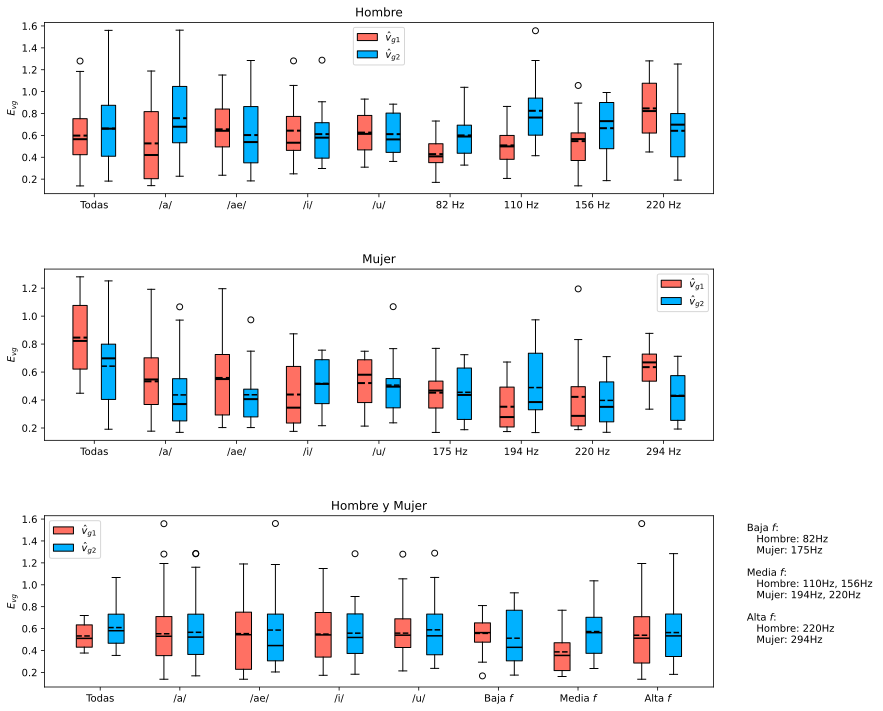

In [ ]:
fig,ax = plt.subplots(3,1,figsize=(12,12))
plt.subplots_adjust(top=None, bottom=None, left=None, right=None, hspace=0.44)

color1= (1, 0.439, 0.388)
color2 = (0, 0.694, 1)

offset = 0.2  # separación horizontal 
for i in range(len(combinacion_archivos[0])):
    ax[0].boxplot(
        Errores_1[i],
        positions=[i - offset],     
        widths=0.2,
        patch_artist=True,
        showmeans=True,
        meanline=True,
        boxprops={'facecolor': color1, 'color': 'black'},
        medianprops={'color': 'black', 'linewidth': 2},
        meanprops={'color': 'black', 'linestyle': '--', 'linewidth': 2},
        whiskerprops={'color': 'black'},
        capprops={'color': 'black'}
    )
    ax[0].boxplot(
        Errores_2[i],
        positions=[i + offset],    
        widths=0.2,
        patch_artist=True,
        showmeans=True,
        meanline=True,
        boxprops={'facecolor': color2, 'color': 'black'},
        medianprops={'color': 'black', 'linewidth': 2},
        meanprops={'color': 'black', 'linestyle': '--', 'linewidth': 2},
        whiskerprops={'color': 'black'},
        capprops={'color': 'black'}
    )
ax[0].set_xticks(range(len(combinacion_archivos[0])))
ax[0].set_xticklabels(etiquetas[0])
ax[0].set_title("Hombre")
ax[0].set_ylabel(r"$E_{vg}$")

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=color1, edgecolor='black', label=r"$\hat{v}_{g1}$"),
    Patch(facecolor=color2, edgecolor='black', label=r"$\hat{v}_{g2}$")
]
ax[0].legend(handles=legend_elements, loc='best')



for i in range(len(combinacion_archivos[1])):
    ax[1].boxplot(
        Errores_1[len(combinacion_archivos[0])-1+ i],
        positions=[i - offset],     
        widths=0.2,
        patch_artist=True,
        showmeans=True,
        meanline=True,
        boxprops={'facecolor': color1, 'color': 'black'},
        medianprops={'color': 'black', 'linewidth': 2},
        meanprops={'color': 'black', 'linestyle': '--', 'linewidth': 2},
        whiskerprops={'color': 'black'},
        capprops={'color': 'black'}
    )
    ax[1].boxplot(
        Errores_2[len(combinacion_archivos[0])-1+i],
        positions=[i + offset],   
        widths=0.2,
        patch_artist=True,
        showmeans=True,
        meanline=True,
        boxprops={'facecolor': color2, 'color': 'black'},
        medianprops={'color': 'black', 'linewidth': 2},
        meanprops={'color': 'black', 'linestyle': '--', 'linewidth': 1.5},
        whiskerprops={'color': 'black'},
        capprops={'color': 'black'}
    )
ax[1].set_xticks(range(len(combinacion_archivos[1])))
ax[1].set_xticklabels(etiquetas[1])
ax[1].set_title("Mujer")
ax[1].set_ylabel(r"$E_{vg}$")

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=color1, edgecolor='black', label=r"$\hat{v}_{g1}$"),
    Patch(facecolor=color2, edgecolor='black', label=r"$\hat{v}_{g2}$")
]
ax[1].legend(handles=legend_elements, loc='best')

for i in range(len(combinacion_archivos[2])):
    ax[2].boxplot(
        Errores_1[len(combinacion_archivos[0])+len(combinacion_archivos[1])-1+ i],
        positions=[i - offset],     
        widths=0.2,
        patch_artist=True,
        showmeans=True,
        meanline=True,
        boxprops={'facecolor': color1, 'color': 'black'},
        medianprops={'color': 'black', 'linewidth': 1.5},
        meanprops={'color': 'black', 'linestyle': '--', 'linewidth': 1.5},
        whiskerprops={'color': 'black'},
        capprops={'color': 'black'}
    )
    ax[2].boxplot(
        Errores_2[len(combinacion_archivos[0])+len(combinacion_archivos[1])-1+i],
        positions=[i + offset],   
        widths=0.2,
        patch_artist=True,
        showmeans=True,
        meanline=True,
        boxprops={'facecolor': color2, 'color': 'black'},
        medianprops={'color': 'black', 'linewidth': 1.5},
        meanprops={'color': 'black', 'linestyle': '--', 'linewidth': 1.5},
        whiskerprops={'color': 'black'},
        capprops={'color': 'black'}
    )

ax[2].set_xticks(range(len(combinacion_archivos[2])))
ax[2].set_xticklabels(etiquetas[2])
ax[2].set_title("Hombre y Mujer")
ax[2].set_ylabel(r"$E_{vg}$")


from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=color1, edgecolor='black', label=r"$\hat{v}_{g1}$"),
    Patch(facecolor=color2, edgecolor='black', label=r"$\hat{v}_{g2}$")
]
ax[2].legend(handles=legend_elements, loc='best')
ax[-1].text(
    1.05, 0.6,    # posición (x,y) relativa al eje (1.0 está justo al borde derecho)
    f"Baja $f$: \n   Hombre: 82Hz \n   Mujer: 175Hz\n\nMedia $f$: \n   Hombre: 110Hz, 156Hz \n   Mujer: 194Hz, 220Hz \n\nAlta $f$: \n   Hombre: 220Hz \n   Mujer: 294Hz",
    transform=ax[-1].transAxes,  # coordenadas relativas al eje
    fontsize=10,
    va='center', ha='left'
);

fig.savefig("Prueba Repositorio II/Boxplots.pdf",bbox_inches = 'tight');
